## Apply the K-Means Algorithm to cluster the dataset
Author: Adrien Loiseau

In [1]:
# Run the help_functions.py script to have acces to the imports and helper functions
%run help_functions.py

##### Load the dataset containing the 500 hPa geopotential height data

In [2]:
file_name = "Data/ERA5_geopotential_500hPa_1940_2025_winter_midnight_Euro_Atlantic.nc"
dataset_dict = load_dataset(file_name=file_name)

winter_months = ["Dec", "Jan", "Feb"]
years_array = np.arange(dataset_dict["first_year"], dataset_dict["last_year"]+1, 1)

Geopotential height dataset (0.25°x0.25°): (nb_days=7731, nb_lats=241, nb_longs=561, grid_size=135201)
Geopotential height dataset (0.50°x0.50°): (nb_days=7731, nb_lats=121, nb_longs=281, grid_size=34001)
Geopotential height data: (7731, 121, 281)
Reshaped geopotential height data: (7731, 34001)
Geopotential height anomalies: (7731, 121, 281)
Reshaped geopotential height anomalies: (7731, 34001)
Daily winter data from 1940 to 2025 successfully loaded. Loading time: 57.20 seconds.


### Apply PCA to the geopotential height anomalies

In [3]:
nb_modes = 9
data_for_PCA = dataset_dict["geopotential_height_anomalies_reshaped"]

### Run PCA with nb_modes modes ###
start_time = time.time()
pca = PCA(n_components=nb_modes).fit(data_for_PCA)
end_time = time.time() ; print(f"PCA algorithm with {nb_modes} modes performed in {end_time-start_time:.2f} seconds.")

### Calculate the explained variance by the first nb_modes PCA modes ###
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Total explained variance by the first {nb_modes} PCA modes: {explained_variance.sum():.2f}%")

### Transform the geopotential height anomalies using the PCA model (Project the data onto the first nb_modes PCA modes) ###
PCA_transformed_data = pca.transform(data_for_PCA)
print(f"Transformed geopotential height shape: {PCA_transformed_data.shape}")
print(f"Principal components shape: {pca.components_.shape}")

data_for_clustering = PCA_transformed_data

PCA algorithm with 9 modes performed in 5.35 seconds.
Total explained variance by the first 9 PCA modes: 76.09%
Transformed geopotential height shape: (7731, 9)
Principal components shape: (9, 34001)


In [4]:
def plot_centroids(nb_clusters, cluster_centers, y_pred, method, cluster_names=None, savefig=False):
    nb_lats = len(dataset_dict["lats"]) ; nb_longs = len(dataset_dict["longs"])

    ### Project the cluster centers back to the original space ###
    centroids_original_space = (cluster_centers @ pca.components_).reshape(nb_clusters, nb_lats, nb_longs)

    ### Sort the clusters in descending order of their frequency of occurrence ###
    frequency_array = np.array([np.sum(y_pred == cluster_idx) / len(y_pred) * 100 for cluster_idx in range(nb_clusters)]) ; sorted_indices = np.argsort(frequency_array)[::-1]

    ncols = 2 ; nrows = int(np.ceil(nb_clusters / ncols)) # ncols = 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3+0.5), constrained_layout=True) # If save: nrows*3+0.5 - else: nrows*3+1

    for cluster_idx in range(nrows*ncols): # Loop over the cluster indices (starting from 0 --> +1)
        row = cluster_idx // ncols ; col = cluster_idx % ncols ; axis_to_plot = axs[col] if (nrows == 1) else axs[row, col]

        if (cluster_idx < nb_clusters):
            if cluster_names is not None: axis_to_plot.set_title(f"Cluster {cluster_idx+1}: {cluster_names[cluster_idx]} ({frequency_array[sorted_indices[cluster_idx]]:.1f}%)", fontsize=20)
            else: axis_to_plot.set_title(f"Cluster {cluster_idx+1} ({frequency_array[sorted_indices[cluster_idx]]:.2f}%)", fontsize=20)
            ### Create the contour plot ###
            m, contour, ticks = create_contour_data(ax=axis_to_plot, dataset_dict=dataset_dict, type_plot="geopotential_height_anomalies_temporal_mean",
                                                    geopotential_height_data_to_plot=(centroids_original_space[sorted_indices[cluster_idx], :]), weather_regime=True)
        else: axis_to_plot.set_visible(False)

    # fig.suptitle(f"Centroids {method} ({nb_clusters} clusters)", fontsize=20)
    cbar = fig.colorbar(contour, ax=axs, ticks=ticks, location='bottom', extend='both', shrink=0.75, pad=0.02, aspect=40)
    cbar.ax.tick_params(axis="x", labelsize=15, length=7.5, width=1)
    cbar.ax.text(x=1.1, y=-1.25, s=r'$[m]$', transform=cbar.ax.transAxes, ha='center', va='center', fontsize=15) # If save: y=-1.25 - else: y=-0.5
    if (savefig == True): plt.savefig(f"Images/KMeans_{nb_clusters}_centroids_PCA_{dataset_dict['first_year']}_{dataset_dict['last_year']}.png", dpi=300, bbox_inches="tight")
    plt.show()

In [5]:
def compute_regime_occurence_per_winter(y_pred_sorted, nb_clusters):
    regime_occurence_per_winter = np.zeros((dataset_dict["last_year"] - dataset_dict["first_year"] + 1, nb_clusters))
    regime_occurence_per_month = np.zeros((nb_clusters, 3))
    for year in years_array:
        if (year == dataset_dict["first_year"]): first_day_idx = 0 ; last_day_idx = 60
        elif (year % 4 == 0): first_day_idx = last_day_idx ; last_day_idx += 91 # Leap year
        else: first_day_idx = last_day_idx ; last_day_idx += 90 # Non-leap year

        for day in range(first_day_idx, last_day_idx, 1): # Loop through the days of the winter
            regime_occurence_per_winter[year - dataset_dict["first_year"], y_pred_sorted[day]] += 1

            if (0 <= day - first_day_idx < 31): month = 0 # December
            elif (31 <= day - first_day_idx < 62): month = 1 # January
            else: month = 2 # February
            regime_occurence_per_month[y_pred_sorted[day], month] += 1

    return regime_occurence_per_winter, regime_occurence_per_month

---
## Four clusters
---

#### Apply K-Means clustering with 4 clusters to the PCA transformed data ####

In [6]:
nb_clusters = 4 ; n_init = 500
start_time = time.time()
kmeans_4 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering)
y_pred_kmeans_4 = kmeans_4.predict(data_for_clustering)
end_time = time.time()
print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

### Sort the predicted labels based on the frequency of occurrence of each cluster ###
frequency_array_kmeans_4 = np.bincount(y_pred_kmeans_4) / len(y_pred_kmeans_4) * 100
sorted_indices_kmeans_4 = np.argsort(frequency_array_kmeans_4)[::-1]
y_pred_sorted_kmeans_4 = np.array([np.argwhere(sorted_indices_kmeans_4 == y_pred_kmeans_4[day])[0][0] for day in range(len(y_pred_kmeans_4))])

K-Means algorithm with 4 clusters performed in 8.27 seconds.


#### Plot the centroids of the four K-Means clusters ####

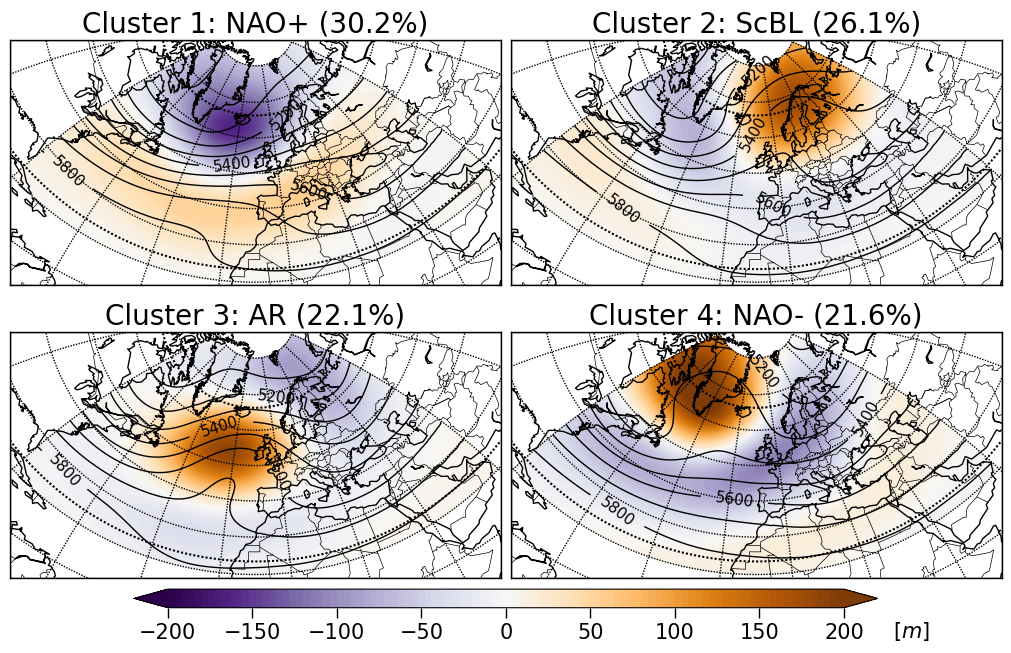

In [7]:
cluster_names_kmeans_4 = ["NAO+", "ScBL", "AR", "NAO-"]
plot_centroids(nb_clusters=len(cluster_names_kmeans_4), cluster_centers=kmeans_4.cluster_centers_, y_pred=y_pred_kmeans_4, method="K-Means", cluster_names=cluster_names_kmeans_4, savefig=False)

#### Compute the occurrences of each regime per winter and per month ####

        NAO+   ScBL     AR   NAO-
count  86.00  86.00  86.00  86.00
mean   27.07  23.55  19.91  19.37
std    14.26  11.10  10.36  14.21
min     0.00   3.00   1.00   0.00
25%    17.00  14.25  12.25   7.25
50%    25.00  23.50  18.50  19.00
75%    38.00  30.75  26.75  28.00
max    59.00  54.00  52.00  62.00

Maximum number of occurrences of the NAO+ regime:
      NAO+  ScBL    AR  NAO-
1990  59.0  13.0   8.0  10.0
2020  59.0   9.0  15.0   8.0
1989  58.0   3.0  29.0   0.0
1995  55.0  11.0  17.0   7.0
1975  53.0  13.0  15.0   9.0

Maximum number of occurrences of the ScBL regime:
      NAO+  ScBL    AR  NAO-
2006  10.0  54.0  17.0   9.0
1972  29.0  47.0  13.0   2.0
1985   8.0  44.0   9.0  29.0
2021   1.0  44.0   5.0  40.0
1947  13.0  43.0   2.0  32.0

Maximum number of occurrences of the AR regime:
      NAO+  ScBL    AR  NAO-
1976  22.0  15.0  52.0   2.0
1944  20.0  26.0  41.0   4.0
1981  29.0  13.0  40.0   8.0
2004  18.0  17.0  39.0  17.0
1968  12.0   4.0  37.0  38.0

Maximum number of oc

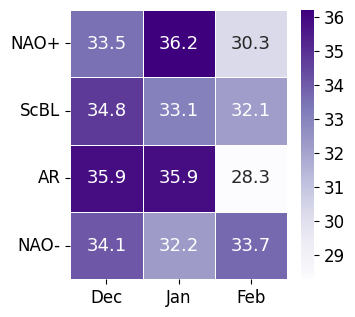

In [83]:
nb_clusters = len(cluster_names_kmeans_4)
result = compute_regime_occurence_per_winter(y_pred_sorted=y_pred_sorted_kmeans_4, nb_clusters=nb_clusters)
(regime_occurence_per_winter_kmeans_4, regime_occurence_per_month_kmeans_4) = result

### Get descriptive statistics of the regime occurrences per winter ### 
df = pd.DataFrame(data=regime_occurence_per_winter_kmeans_4, index=years_array, columns=cluster_names_kmeans_4)
print(df.describe().round(2))

### Get the winters with the 5 most frequent weather regimes ###
for regime in cluster_names_kmeans_4:
    print(f"\nMaximum number of occurrences of the {regime} regime:")
    print(df.nlargest(n=5, columns=regime))

print("\nRegime occurrences per winter (K-Means 4 clusters):")
print(regime_occurence_per_month_kmeans_4)

### Plot the regimes occurrences per month ###
fig, ax = plt.subplots(figsize=(3.5, 3.5))
regime_occurence_per_month_kmeans_4 = regime_occurence_per_month_kmeans_4 / np.sum(regime_occurence_per_month_kmeans_4, axis=1, keepdims=True) * 100 # Normalise to percentage
ax = sns.heatmap(regime_occurence_per_month_kmeans_4, cmap="Purples", annot=True, fmt=".1f", linewidths=0.5, annot_kws={"size": 13}, xticklabels=winter_months, yticklabels=cluster_names_kmeans_4)
cbar = ax.collections[0].colorbar ; cbar.ax.tick_params(labelsize=12) ; ax.tick_params(labelsize=12, rotation=0)
# plt.savefig("Images/KMeans_4_clusters_regime_occurence_per_month.png", dpi=300, bbox_inches="tight")
plt.show()

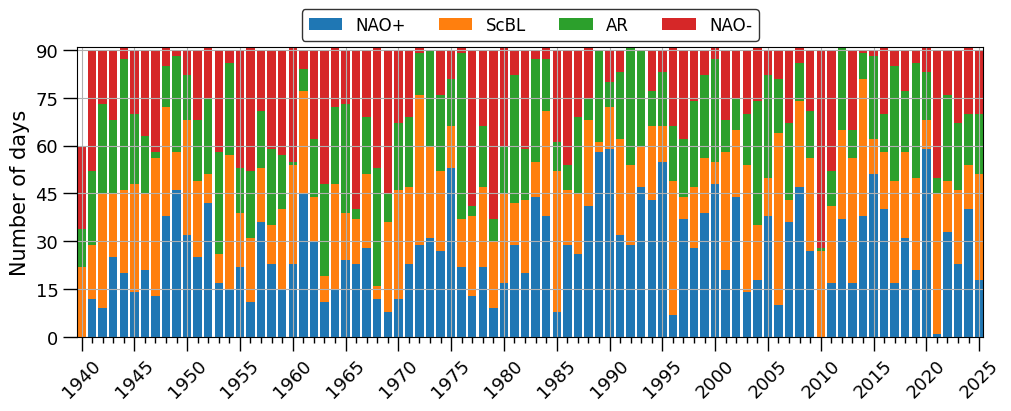

In [84]:
### Plot the regime occurrences per winter ###
fig, axs = plt.subplots(figsize=(10, 4), constrained_layout=True) ; nb_clusters = 4
bottom = np.zeros(len(years_array))
for cluster_idx in range(nb_clusters):
    axs.bar(x=years_array, height=regime_occurence_per_winter_kmeans_4[:, cluster_idx], label=f"{cluster_names_kmeans_4[cluster_idx]}", bottom=bottom)
    bottom += regime_occurence_per_winter_kmeans_4[:, cluster_idx]

axs.set_xticks(ticks=years_array, minor=True)
xticks_labels = years_array[::5] ; axs.set_xticks(ticks=xticks_labels, labels=xticks_labels, minor=False, rotation=45)
axs.set_yticks(ticks=np.arange(0, 91, 15), minor=False)
axs.set_ylabel("Number of days", fontsize=15) # ; axs.set_xlabel("Year", fontsize=15)
axs.tick_params(which='major', length=10, width=1, labelsize=13) ; axs.tick_params(which='minor', length=4, width=1)
axs.margins(x=0, y=0) ; axs.grid() ; axs.legend(bbox_to_anchor=(0.5, 1.075), ncols=nb_clusters, loc='center', fontsize=12, edgecolor='black')
plt.show()

Average number of occurrences of the NAO+ regime: 27.1 days


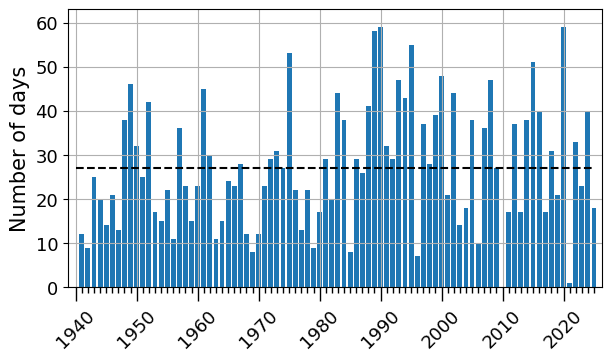

Average number of occurrences of the ScBL regime: 23.5 days


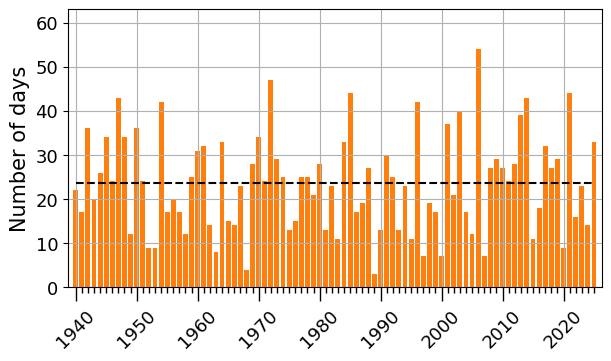

Average number of occurrences of the AR4 regime: 19.9 days


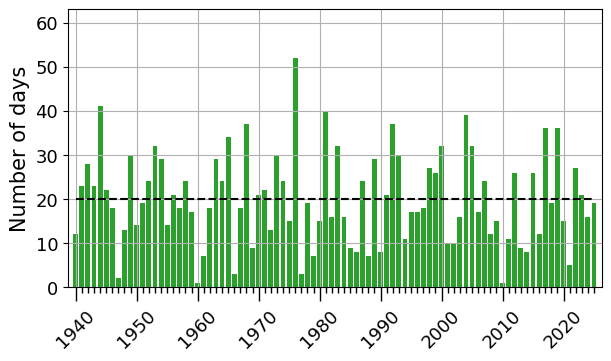

Average number of occurrences of the NAO- regime: 19.4 days


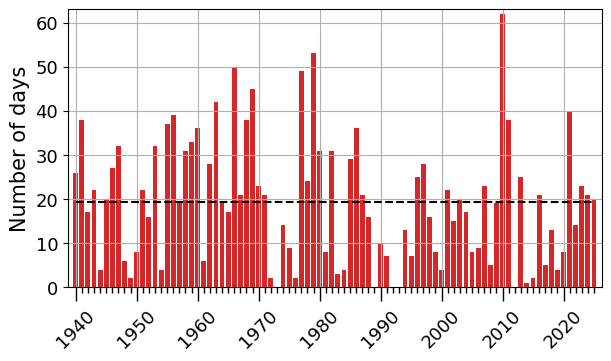

Average number of occurrences per winter for all regimes: 89.90 days (= 7731 days / 86 winters)


In [22]:
### Plot the regime occurrences per winter for each cluster ###
nb_clusters = len(cluster_names_kmeans_4)
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), constrained_layout=True, sharex=True, sharey=True) ; nb_clusters = 4
# for cluster_idx in range(nb_clusters):
#     axis_to_plot = axs[cluster_idx//2, cluster_idx%2]
#     axis_to_plot.bar(x=years_array, height=regime_occurence_per_winter_kmeans_4[:, cluster_idx], color=matplotlib.colormaps.get_cmap("tab10")(cluster_idx))
#     axis_to_plot.set_title(f"Cluster {cluster_idx+1}: {cluster_names_kmeans_4[cluster_idx]} ({frequency_array_kmeans_4[sorted_indices_kmeans_4[cluster_idx]]:.2f}%)", fontsize=15)

#     axis_to_plot.margins(x=0.01, y=0.05) ; axis_to_plot.grid()
#     axis_to_plot.set_xticks(ticks=years_array, minor=True)
#     xticks_labels = years_array[::10] ; axis_to_plot.set_xticks(ticks=xticks_labels, labels=xticks_labels, minor=False, rotation=45)
#     axis_to_plot.tick_params(axis='x', which='major', length=10, width=1, labelsize=13) ; axis_to_plot.tick_params(which='minor', length=4, width=1)
#     if (cluster_idx //2 == 1): axis_to_plot.set_xlabel("Year", fontsize=15)
#     if (cluster_idx % 2 == 0):  axis_to_plot.set_ylabel("Number of days", fontsize=15)
#     axis_to_plot.set_yticks(ticks=np.arange(0, np.max(regime_occurence_per_winter_kmeans_4), 10), labels=np.arange(0, int(np.max(regime_occurence_per_winter_kmeans_4)), 10), fontsize=13)
# plt.show()

sum_of_average_nb_occurrences = 0
for cluster_idx in range(nb_clusters):
    plt.figure(figsize=(6, 3.5), constrained_layout=True)
    plt.bar(x=years_array, height=regime_occurence_per_winter_kmeans_4[:, cluster_idx], color=matplotlib.colormaps.get_cmap("tab10")(cluster_idx))
    # plt.title(f"Cluster {cluster_idx+1}: {cluster_names_kmeans_4[cluster_idx]} ({frequency_array_kmeans_4[sorted_indices_kmeans_4[cluster_idx]]:.1f}%)", fontsize=15)

    mean_nb_occurrences = np.mean(regime_occurence_per_winter_kmeans_4[:, cluster_idx]) ; sum_of_average_nb_occurrences += mean_nb_occurrences
    print(f"Average number of occurrences of the {cluster_names_kmeans_4[cluster_idx]} regime: {mean_nb_occurrences:.1f} days")
    plt.hlines(y=np.mean(regime_occurence_per_winter_kmeans_4[:, cluster_idx]), xmin=years_array[0], xmax=years_array[-1], color="black", linestyle="--", linewidth=1.5)

    ax = plt.gca() ; ax.margins(x=0.01) ; plt.grid() ; plt.xticks(ticks=years_array[::10], labels=years_array[::10], rotation=45, fontsize=13)
    plt.xticks(ticks=years_array, minor=True) ; ax.tick_params(which='minor', length=4, width=1)
    ax.tick_params(axis='x', which='major', length=10, width=1, labelsize=13)
    plt.yticks(ticks=np.arange(0, np.max(regime_occurence_per_winter_kmeans_4), 10), labels=np.arange(0, int(np.max(regime_occurence_per_winter_kmeans_4)), 10), fontsize=13)
    plt.ylabel("Number of days", fontsize=15) ; plt.ylim(bottom=0, top=np.max(regime_occurence_per_winter_kmeans_4)+1)
    # plt.savefig(f"Images/KMeans_{nb_clusters}_clusters_regime_occurrences_cluster_{cluster_idx+1}.png", dpi=300, bbox_inches="tight")
    plt.show()

print(f"Average number of occurrences per winter for all regimes: {sum_of_average_nb_occurrences:.2f} days (= 7731 days / 86 winters)")

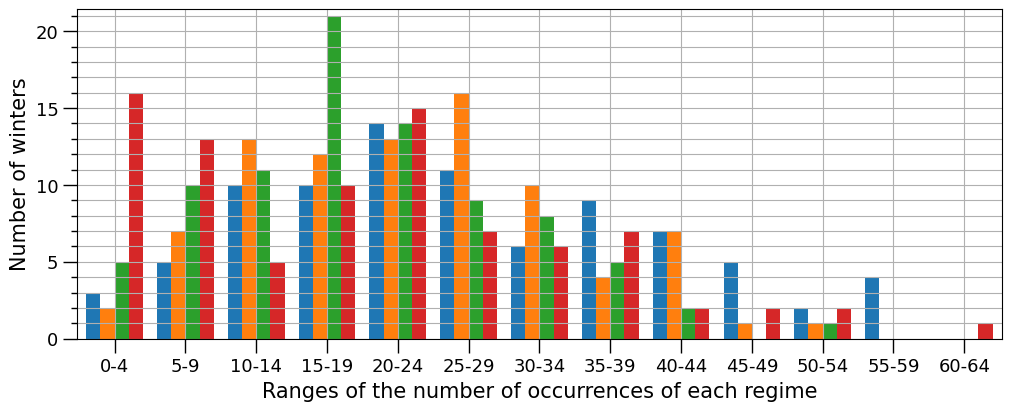

In [23]:
### Plot a histogram of the regime occurrence per winter, where the x-axis is the number of days in the regime for the values (0-10, 10-20, 20-30, etc.) ###
fig, axs = plt.subplots(figsize=(10, 4), constrained_layout=True) ; step = 5
axs.hist(x=df, bins=range(0, int(np.max(regime_occurence_per_winter_kmeans_4)) + step, step), label=f"Cluster {cluster_idx+1}", linewidth=2)
axs.set_xticks(ticks=np.arange(0, int(np.max(regime_occurence_per_winter_kmeans_4)), step) + step/2, labels=[f"{i}-{i+step-1}" for i in range(0, int(np.max(regime_occurence_per_winter_kmeans_4)), step)])
axs.set_xlabel("Ranges of the number of occurrences of each regime", fontsize=15) ; axs.set_ylabel("Number of winters", fontsize=15)
axs.tick_params(which='major', length=10, width=1, labelsize=13) ; axs.tick_params(which='minor', length=4, width=1)
axs.set_yticks(ticks=np.arange(0, 25+1, 5), labels=np.arange(0, 25+1, 5), fontsize=13, minor=False) ; axs.set_yticks(ticks=np.arange(0, 25+1, 1), minor=True)
axs.margins(x=0.01, y=0.02) ; axs.grid(which='both', axis='both') # ; axs.legend(bbox_to_anchor=(0.5, 1.075), ncols=nb_clusters, loc='center', fontsize=12, edgecolor='black')
plt.show()

#### Project the K-Means centroids onto the leading PCs ####

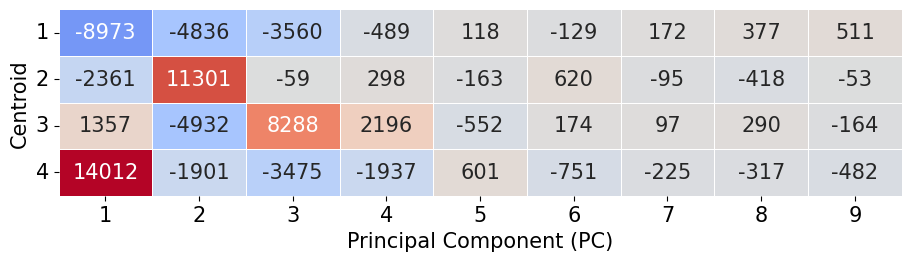

In [24]:
nb_clusters = 4 ; nb_modes_to_keep = 9
centroids_original_space = (kmeans_4.cluster_centers_[sorted_indices_kmeans_4] @ pca.components_)
projection_of_centroids = pca.transform(centroids_original_space)[:, :nb_modes_to_keep]

plt.figure(figsize=(nb_modes_to_keep, 2.5), constrained_layout=True) # ; plt.gca().set_aspect('equal')
sns.heatmap(projection_of_centroids, annot=True, fmt=".0f", cmap="coolwarm", annot_kws={"fontsize":15}, linewidths=0.5, center=0, cbar=False)
plt.xticks(np.arange(0.5, nb_modes_to_keep+0.5), [f"{mode_idx+1}" for mode_idx in range(nb_modes_to_keep)], fontsize=15, rotation=0)
plt.yticks(np.arange(0.5, nb_clusters+0.5), [f"{cluster_idx+1}" for cluster_idx in range(nb_clusters)], fontsize=15, rotation=0) # cluster_names[cluster_idx]
plt.xlabel("Principal Component (PC)", fontsize=15) ; plt.ylabel("Centroid", fontsize=15)
# plt.savefig(f"Images/projection_KMeans_{nb_clusters}_centroids_on_PCA_modes.png", dpi=300, bbox_inches="tight")
plt.show()

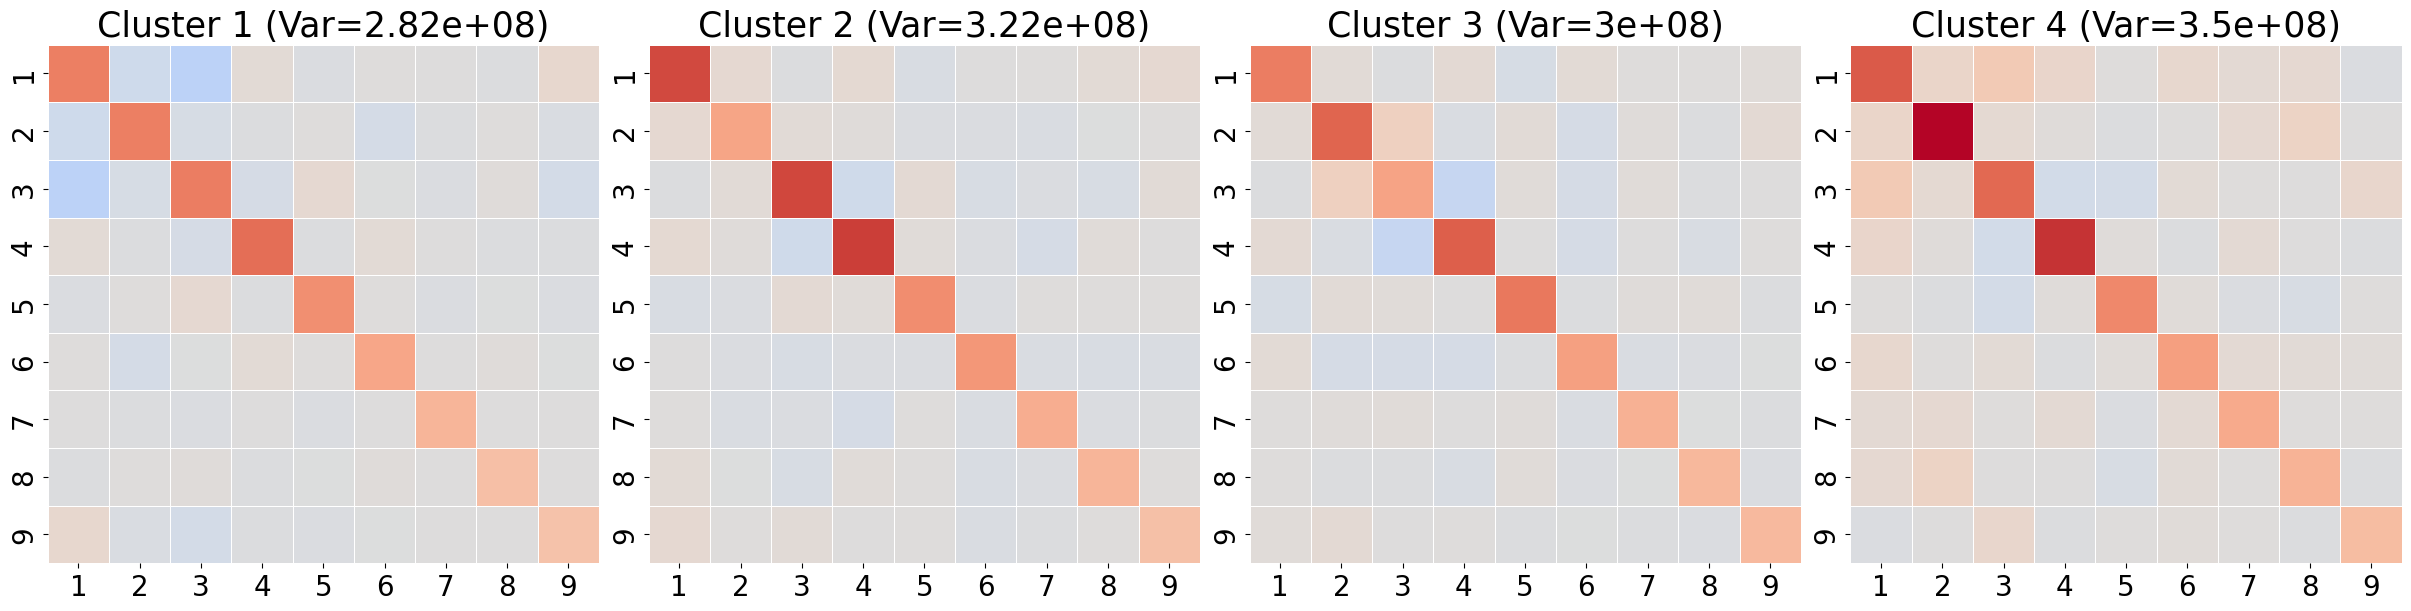

In [25]:
nb_clusters = 4 ; nb_modes_to_keep = 9 ; heatmap_labels = np.arange(nb_modes_to_keep) + 1
ncols = 4 ; nrows = int(np.ceil(nb_clusters / ncols)) ; fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6), constrained_layout=True)
covariance_matrix = np.zeros((nb_clusters, nb_modes_to_keep, nb_modes_to_keep)) ; variance_array = np.zeros(nb_clusters)
for cluster_idx in range(nb_clusters):
    cluster_data = data_for_clustering[y_pred_sorted_kmeans_4 == cluster_idx]
    covariance_matrix[cluster_idx] = np.cov(cluster_data, rowvar=False)[:nb_modes_to_keep, :nb_modes_to_keep]
    variance_array[cluster_idx] = np.var(cluster_data, axis=0).sum()
covariance_matrix /= 1e7

for cluster_idx in range(nb_clusters):
    axis_to_plot = axs[cluster_idx % ncols] if (nrows == 1) else axs[cluster_idx // ncols, cluster_idx % ncols]
    axis_to_plot.set_title(f"Cluster {cluster_idx+1} (Var={variance_array[cluster_idx]:.3g})", fontsize=25)
    sns.heatmap(covariance_matrix[cluster_idx], annot=False, fmt=".1f", cmap="coolwarm", linewidths=0.5, center=0, cbar=False, vmin=np.min(covariance_matrix), vmax=np.max(covariance_matrix), ax=axis_to_plot, xticklabels=heatmap_labels, yticklabels=heatmap_labels, annot_kws={"fontsize":15})
    axis_to_plot.tick_params(labelsize=20)
plt.show()

---
## Seven clusters
---

#### Apply K-Means clustering with 4 clusters to the PCA transformed data ####

In [8]:
nb_clusters = 7 ; n_init = 500
start_time = time.time()
kmeans_7 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering)
y_pred_kmeans_7 = kmeans_7.predict(data_for_clustering)
end_time = time.time()
print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

### Sort the predicted labels based on the frequency of occurrence of each cluster ###
frequency_array_kmeans_7 = np.bincount(y_pred_kmeans_7) / len(y_pred_kmeans_7) * 100
sorted_indices_kmeans_7 = np.argsort(frequency_array_kmeans_7)[::-1]
y_pred_sorted_kmeans_7 = np.array([np.argwhere(sorted_indices_kmeans_7 == y_pred_kmeans_7[day])[0][0] for day in range(len(y_pred_kmeans_7))])

K-Means algorithm with 7 clusters performed in 9.48 seconds.


#### Plot the centroids of the four K-Means clusters ####

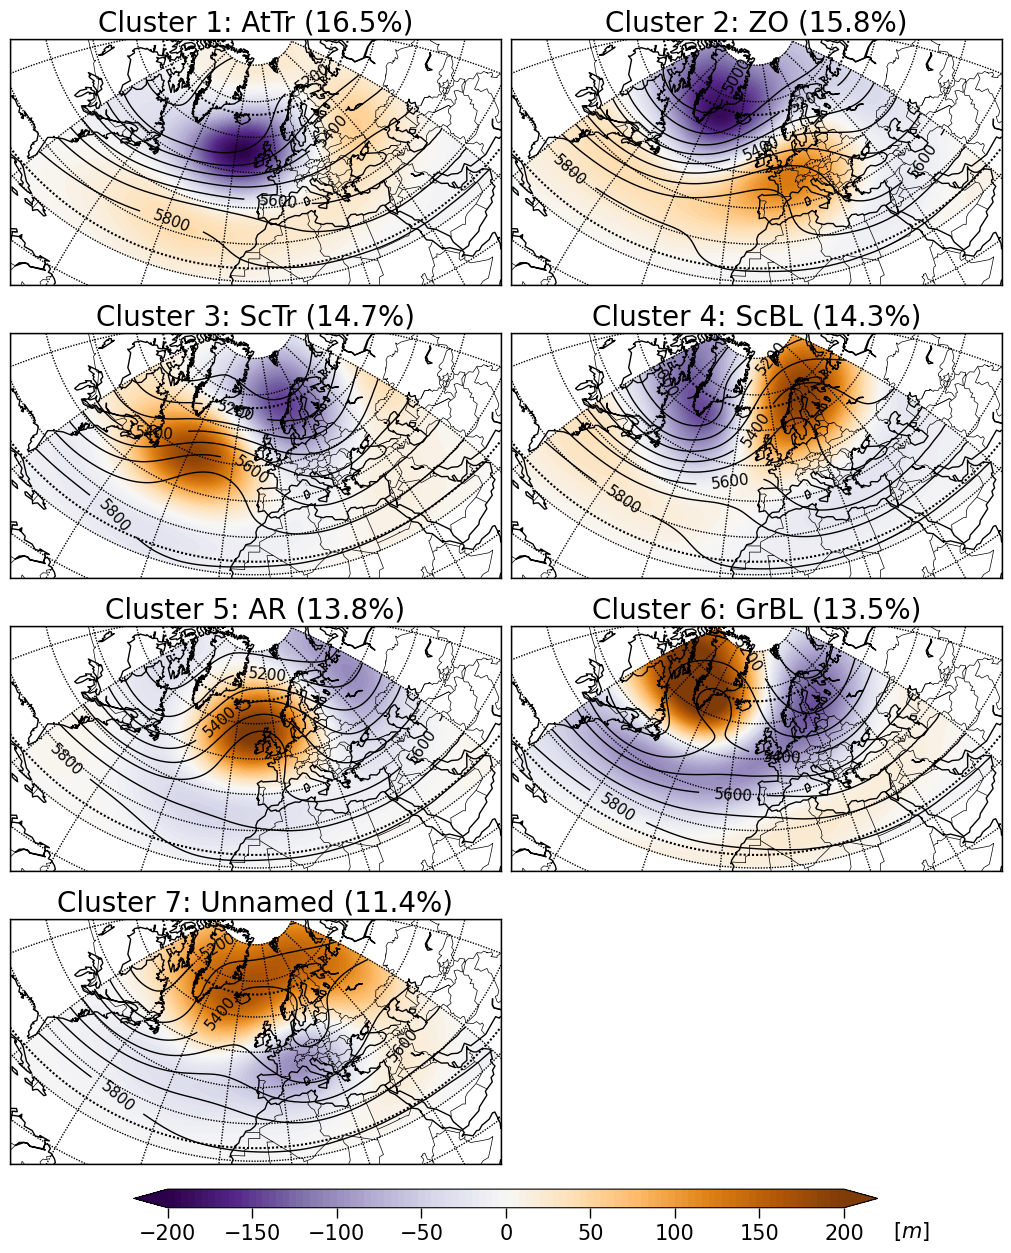

In [9]:
cluster_names_kmeans_7 = ["AtTr", "ZO", "ScTr", "ScBL", "AR", "GrBL", "Unnamed"]
plot_centroids(nb_clusters=len(cluster_names_kmeans_7), cluster_centers=kmeans_7.cluster_centers_, y_pred=y_pred_kmeans_7, method="K-Means", cluster_names=cluster_names_kmeans_7, savefig=False)

#### Compute the occurrences of each regime per winter and per month ####

        AtTr     ZO   ScTr   ScBL     AR   GrBL  Unnamed
count  86.00  86.00  86.00  86.00  86.00  86.00    86.00
mean   14.90  14.21  13.41  13.35  12.16  11.71    10.16
std     9.86  10.73   8.71   8.21   7.87   9.66     9.28
min     0.00   0.00   0.00   0.00   0.00   0.00     0.00
25%     7.00   6.00   7.00   7.00   7.00   4.00     4.00
50%    13.00  12.50  12.50  11.00  11.00  11.00     9.00
75%    20.75  19.00  19.00  17.75  16.00  18.75    14.00
max    57.00  54.00  35.00  39.00  39.00  36.00    48.00

Maximum number of occurrences of the AtTr regime:
      AtTr    ZO  ScTr  ScBL    AR  GrBL  Unnamed
2014  57.0  10.0   4.0  11.0   2.0   0.0      6.0
2001  38.0   7.0   2.0   7.0  10.0  14.0     12.0
1977  35.0   1.0   1.0  11.0   1.0  20.0     21.0
1988  35.0  10.0   0.0   7.0  13.0  12.0     14.0
1995  32.0  24.0  17.0   7.0   4.0   6.0      0.0

Maximum number of occurrences of the ZO regime:
      AtTr    ZO  ScTr  ScBL    AR  GrBL  Unnamed
1989   6.0  54.0  13.0   3.0  14.0   

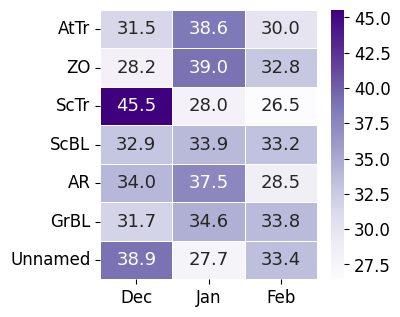

In [86]:
nb_clusters = len(cluster_names_kmeans_7)
regime_occurence_per_winter_kmeans_7, regime_occurence_per_month_kmeans_7 = compute_regime_occurence_per_winter(y_pred_sorted=y_pred_sorted_kmeans_7, nb_clusters=nb_clusters)

### Get descriptive statistics of the regime occurrence per winter ### 
df = pd.DataFrame(data=regime_occurence_per_winter_kmeans_7, index=years_array, columns=cluster_names_kmeans_7)
print(df.describe().round(2))

### Get the winters with the 5 most frequent weather regimes ###
for regime in cluster_names_kmeans_7:
    print(f"\nMaximum number of occurrences of the {regime} regime:")
    print(df.nlargest(n=5, columns=regime))

print("\nRegime occurrences per winter (K-Means 7 clusters):")
print(regime_occurence_per_month_kmeans_7)

### Plot the regimes occurrences per month ###
fig, ax = plt.subplots(figsize=(3.5, 3.5))
regime_occurence_per_month_kmeans_7 = regime_occurence_per_month_kmeans_7 / np.sum(regime_occurence_per_month_kmeans_7, axis=1, keepdims=True) * 100 # Normalise to percentage
sns.heatmap(regime_occurence_per_month_kmeans_7, cmap="Purples", annot=True, fmt=".1f", linewidths=0.5, annot_kws={"size": 13}, xticklabels=winter_months, yticklabels=cluster_names_kmeans_7)
cbar = ax.collections[0].colorbar ; cbar.ax.tick_params(labelsize=12) ; ax.tick_params(labelsize=12)
# plt.savefig("Images/KMeans_7_clusters_regime_occurence_per_month.png", dpi=300, bbox_inches="tight")
plt.show()

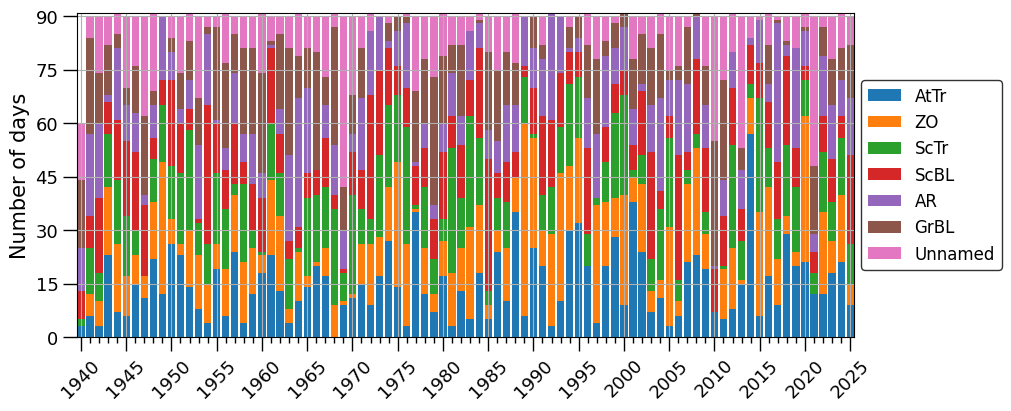

In [87]:
### Plot the regime occurrence per winter ###
fig, axs = plt.subplots(figsize=(10, 4), constrained_layout=True) ; nb_clusters = 7
bottom = np.zeros(len(years_array))
for cluster_idx in range(nb_clusters):
    axs.bar(x=years_array, height=regime_occurence_per_winter_kmeans_7[:, cluster_idx], label=f"{cluster_names_kmeans_7[cluster_idx]}", bottom=bottom, color=matplotlib.colormaps.get_cmap("tab10")(cluster_idx))
    bottom += regime_occurence_per_winter_kmeans_7[:, cluster_idx]

axs.set_xticks(ticks=years_array, minor=True)
xticks_labels = years_array[::5] ; axs.set_xticks(ticks=xticks_labels, labels=xticks_labels, minor=False, rotation=45)
axs.set_yticks(ticks=np.arange(0, 91, 15), minor=False) ; axs.set_ylabel("Number of days", fontsize=15)
axs.tick_params(which='major', length=10, width=1, labelsize=13) ; axs.tick_params(which='minor', length=4, width=1)
axs.margins(x=0, y=0) ; axs.grid() ; axs.legend(bbox_to_anchor=(1.1, 0.5), ncols=1, loc='center', fontsize=12, edgecolor='black')
plt.show()

Average number of occurrences of the AtTr regime: 14.90 days
Average number of occurrences of the ZO regime: 14.21 days
Average number of occurrences of the ScTr regime: 13.41 days
Average number of occurrences of the ScBL regime: 13.35 days
Average number of occurrences of the AR regime: 12.16 days
Average number of occurrences of the GrBL regime: 11.71 days
Average number of occurrences of the Unnamed regime: 10.16 days


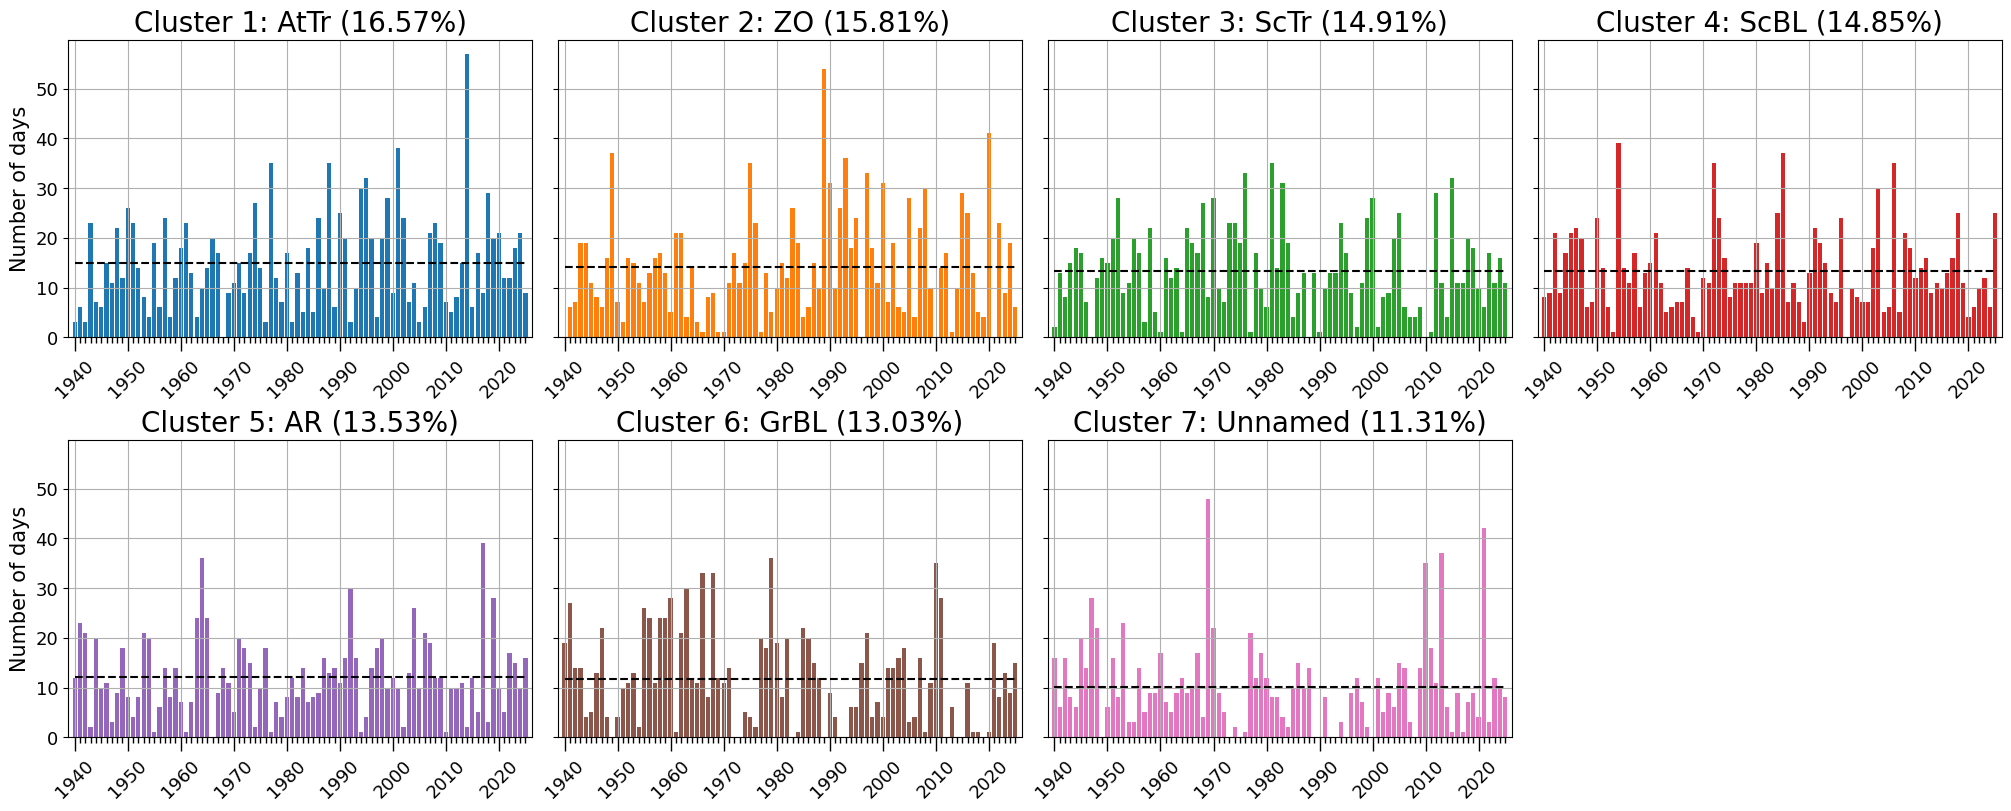

Average number of occurrences per winter for all regimes: 89.90 days (= 7731 days / 86 winters)


In [88]:
### Plot the regime occurrences per winter for each cluster ###
nb_clusters = 7 ; ncols = 4 ; nrows = int(np.ceil(nb_clusters / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 8), constrained_layout=True, sharey=True)

sum_of_average_nb_occurrences = 0
for cluster_idx in range(nrows*ncols):
    axis_to_plot = axs[cluster_idx // ncols, cluster_idx % ncols]
    if (cluster_idx >= nb_clusters): axis_to_plot.set_visible(False) ; continue

    axis_to_plot.bar(x=years_array, height=regime_occurence_per_winter_kmeans_7[:, cluster_idx], color=matplotlib.colormaps.get_cmap("tab10")(cluster_idx))
    axis_to_plot.set_title(f"Cluster {cluster_idx+1}: {cluster_names_kmeans_7[cluster_idx]} ({frequency_array_kmeans_7[sorted_indices_kmeans_7[cluster_idx]]:.2f}%)", fontsize=20)

    mean_nb_occurrences = np.mean(regime_occurence_per_winter_kmeans_7[:, cluster_idx]) ; sum_of_average_nb_occurrences += mean_nb_occurrences
    print(f"Average number of occurrences of the {cluster_names_kmeans_7[cluster_idx]} regime: {mean_nb_occurrences:.2f} days")
    axis_to_plot.hlines(y=np.mean(regime_occurence_per_winter_kmeans_7[:, cluster_idx]), xmin=years_array[0], xmax=years_array[-1], color="black", linestyle="--", linewidth=1.5)

    axis_to_plot.margins(x=0.01, y=0.05) ; axis_to_plot.grid()
    axis_to_plot.set_xticks(ticks=years_array, minor=True)
    xticks_labels = years_array[::10] ; axis_to_plot.set_xticks(ticks=xticks_labels, labels=xticks_labels, minor=False, rotation=45)
    axis_to_plot.tick_params(axis='x', which='major', length=10, width=1, labelsize=13) ; axis_to_plot.tick_params(which='minor', length=4, width=1)
    if (cluster_idx % ncols == 0):  axis_to_plot.set_ylabel("Number of days", fontsize=15) # Only for the first column
    axis_to_plot.set_yticks(ticks=np.arange(0, np.max(regime_occurence_per_winter_kmeans_7), 10), labels=np.arange(0, int(np.max(regime_occurence_per_winter_kmeans_7)), 10), fontsize=13)
plt.show()
print(f"Average number of occurrences per winter for all regimes: {sum_of_average_nb_occurrences:.2f} days (= 7731 days / 86 winters)")

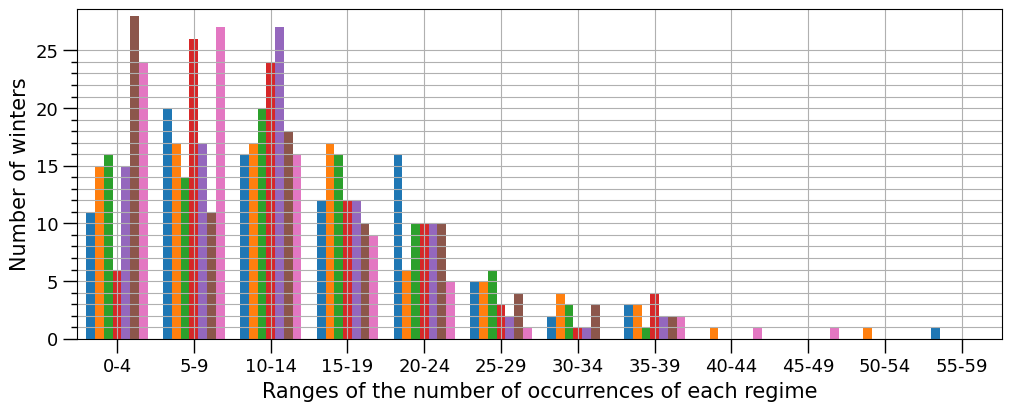

In [48]:
### Plot a histogram of the regime occurrence per winter, where the x-axis is the number of days in the regime for the values (0-10, 10-20, 20-30, etc.) ###
fig, axs = plt.subplots(figsize=(10, 4), constrained_layout=True) ; step = 5
axs.hist(x=df, bins=range(0, int(np.max(regime_occurence_per_winter_kmeans_7)) + step, step), label=f"Cluster {cluster_idx+1}", linewidth=2)
axs.set_xticks(ticks=np.arange(0, int(np.max(regime_occurence_per_winter_kmeans_7)), step) + step/2, labels=[f"{i}-{i+step-1}" for i in range(0, int(np.max(regime_occurence_per_winter_kmeans_7)), step)])
axs.set_xlabel("Ranges of the number of occurrences of each regime", fontsize=15) ; axs.set_ylabel("Number of winters", fontsize=15)
axs.tick_params(which='major', length=10, width=1, labelsize=13) ; axs.tick_params(which='minor', length=4, width=1)
axs.set_yticks(ticks=np.arange(0, 25+1, 5), labels=np.arange(0, 25+1, 5), fontsize=13, minor=False) ; axs.set_yticks(ticks=np.arange(0, 25+1, 1), minor=True)
axs.margins(x=0.01, y=0.02) ; axs.grid(which='both', axis='both') # ; axs.legend(bbox_to_anchor=(0.5, 1.075), ncols=nb_clusters, loc='center', fontsize=12, edgecolor='black')
plt.show()

#### Project the K-Means centroids onto the leading PCs ####

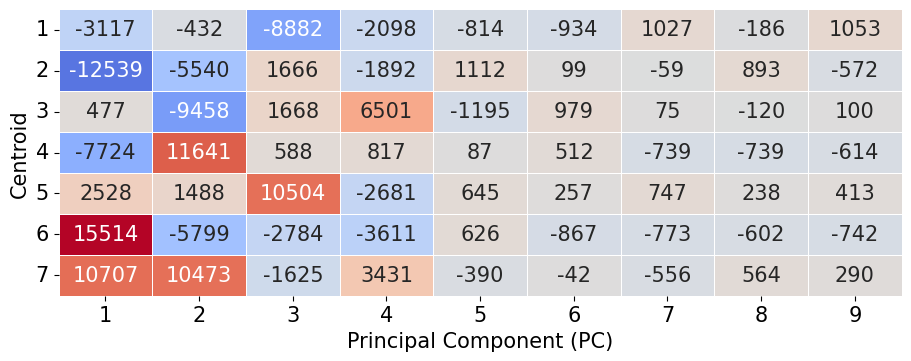

In [49]:
nb_clusters = 7 ; nb_modes_to_keep = 9
centroids_original_space = (kmeans_7.cluster_centers_[sorted_indices_kmeans_7] @ pca.components_)
projection_of_centroids = pca.transform(centroids_original_space)[:, :nb_modes_to_keep]

plt.figure(figsize=(nb_modes_to_keep, 3.5), constrained_layout=True) # ; plt.gca().set_aspect('equal')
sns.heatmap(projection_of_centroids, annot=True, fmt=".0f", cmap="coolwarm", annot_kws={"fontsize":15}, linewidths=0.5, center=0, cbar=False)
plt.xticks(np.arange(0.5, nb_modes_to_keep+0.5), [f"{mode_idx+1}" for mode_idx in range(nb_modes_to_keep)], fontsize=15, rotation=0)
plt.yticks(np.arange(0.5, nb_clusters+0.5), [f"{cluster_idx+1}" for cluster_idx in range(nb_clusters)], fontsize=15, rotation=0) # cluster_names[cluster_idx]
plt.xlabel("Principal Component (PC)", fontsize=15) ; plt.ylabel("Centroid", fontsize=15)
# plt.savefig(f"Images/projection_KMeans_{nb_clusters}_centroids_on_PCA_modes.png", dpi=300, bbox_inches="tight")
plt.show()

---
## Four vs Seven Clusters
---

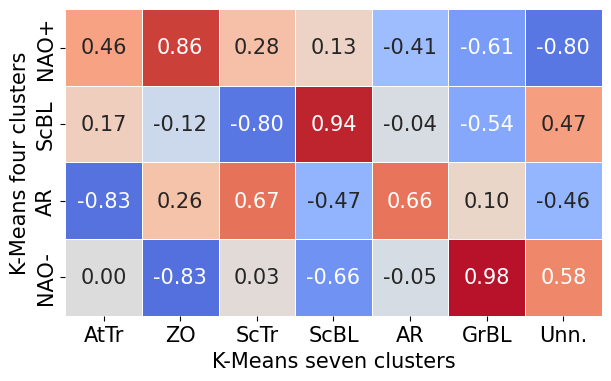

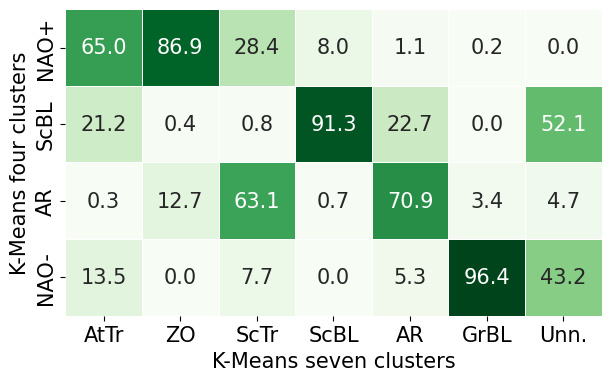

In [ ]:
nb_clusters_kmeans_4 = 4 ; nb_clusters_kmeans_7 = 7
cluster_names_kmeans_7_ = np.concatenate((cluster_names_kmeans_7[:-1], ["Unn."])) # ; print(cluster_names_kmeans_7_)

# Correlation between the centroids of the different clustering methods
correlation_KMeans_4_vs_7 = np.zeros((nb_clusters_kmeans_4, nb_clusters_kmeans_7))
number_of_similar_predictions = np.zeros((nb_clusters_kmeans_4, nb_clusters_kmeans_7))
for i in range(nb_clusters_kmeans_4):
    for j in range(nb_clusters_kmeans_7):
        correlation_KMeans_4_vs_7[i, j] = np.corrcoef(kmeans_4.cluster_centers_[sorted_indices_kmeans_4[i], :].flatten(), kmeans_7.cluster_centers_[sorted_indices_kmeans_7[j], :].flatten())[0, 1]
        ### Count number of samples within cluster i of KMeans 4 and j of KMeans 7 ###
        mask = (y_pred_sorted_kmeans_4 == i) & (y_pred_sorted_kmeans_7 == j) ; count = np.sum(mask) ; number_of_similar_predictions[i, j] = count / np.sum(y_pred_sorted_kmeans_7 == j) * 100

fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
sns.heatmap(correlation_KMeans_4_vs_7, annot=True, fmt=".2f", annot_kws={"fontsize":15}, cmap="coolwarm", cbar=False, ax=axs, square=True, linewidths=0.5, center=0, vmin=-1, vmax=1)
axs.set_xlabel("K-Means seven clusters", fontsize=15) ; axs.set_ylabel("K-Means four clusters", fontsize=15)
# axs.set_xticklabels(np.arange(nb_clusters_kmeans_7)+1, fontsize=13) ; axs.set_yticklabels(np.arange(nb_clusters_kmeans_4)+1, fontsize=13)
axs.set_xticks(np.arange(nb_clusters_kmeans_7) + 0.5, labels=cluster_names_kmeans_7_, fontsize=15) ; axs.set_yticks(np.arange(nb_clusters_kmeans_4) + 0.5, labels=cluster_names_kmeans_4, fontsize=15)
# plt.savefig(f"Images/KMeans_4_vs_7_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
sns.heatmap(number_of_similar_predictions, annot=True, fmt=".1f", annot_kws={"fontsize":15}, cmap="Greens", cbar=False, ax=axs, square=True, linewidths=0.5, vmin=0, vmax=np.max(number_of_similar_predictions))
axs.set_xlabel("K-Means seven clusters", fontsize=15) ; axs.set_ylabel("K-Means four clusters", fontsize=15)
# axs.set_xticklabels(np.arange(nb_clusters_kmeans_7)+1, fontsize=13) ; axs.set_yticklabels(np.arange(nb_clusters_kmeans_4)+1, fontsize=13)
axs.set_xticks(np.arange(nb_clusters_kmeans_7) + 0.5, labels=cluster_names_kmeans_7_, fontsize=15) ; axs.set_yticks(np.arange(nb_clusters_kmeans_4) + 0.5, labels=cluster_names_kmeans_4, fontsize=15)
# plt.savefig(f"Images/KMeans_4_vs_7_number_of_similar_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

---
## Link with the temperature in Brussels
---

In [151]:
df = pd.read_csv("Data/dailyStatistics_T2m_Bruxelles.csv")
print(df)

       AAAA-MM-JJ   moyenne (°C)   min (°C)   max (°C)
0      1959-01-01           5.21       2.17       7.06
1      1959-01-02           4.77       2.06       6.78
2      1959-01-03           2.33       0.47       3.47
3      1959-01-04           0.71      -1.04       1.98
4      1959-01-05           1.67      -0.08       3.04
...           ...            ...        ...        ...
23973  2024-09-06          16.96      15.76      17.52
23974  2024-09-07          19.41      13.12      25.54
23975  2024-09-08          17.49      14.62      20.36
23976  2024-09-09          15.99      14.31      19.05
23977  2024-09-10          14.33      11.98      16.25

[23978 rows x 4 columns]


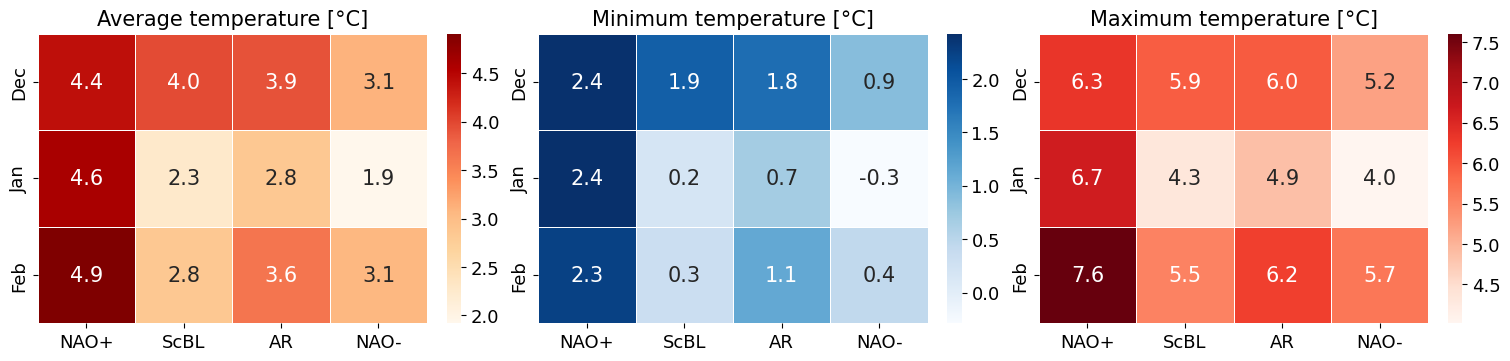

In [93]:
method = "KMeans" ; nb_clusters = 4 ; cluster_names = cluster_names_kmeans_4
avg_temperature, min_temperature, max_temperature, number_of_days_with_temperature = retrieve_temperature_data_for_clusters(y_pred=y_pred_sorted_kmeans_4, nb_clusters=nb_clusters, dataset_dict=dataset_dict)

### One large plot ###
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 3.5), constrained_layout=True)
ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(avg_temperature), vmax=np.max(avg_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[0])
axs[0].set_title("Average temperature [°C]", fontsize=15) ; axs[0].tick_params(labelsize=13) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(min_temperature), vmax=np.max(min_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[1])
axs[1].set_title("Minimum temperature [°C]", fontsize=15) ; axs[1].tick_params(labelsize=13) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(max_temperature), vmax=np.max(max_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[2])
axs[2].set_title("Maximum temperature [°C]", fontsize=15) ; axs[2].tick_params(labelsize=13) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)
plt.show()

# ### Average temperature per regime ###
# plt.figure(figsize=(4, 3), constrained_layout=True)
# ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=1.5, vmax=5.5, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Average temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_avg_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

# ### Minimum temperature per regime ###
# plt.figure(figsize=(4, 3), constrained_layout=True)
# # vmin = np.floor(np.min(min_temperature) * 2) / 2 ; vmax = np.ceil(np.max(min_temperature) * 2) / 2 
# ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=-0.5, vmax=2.5, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Minimum temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_min_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

# ### Maximum temperature per regime ###
# plt.figure(figsize=(4, 3), constrained_layout=True)
# ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=3.5, vmax=8, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Maximum temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_max_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

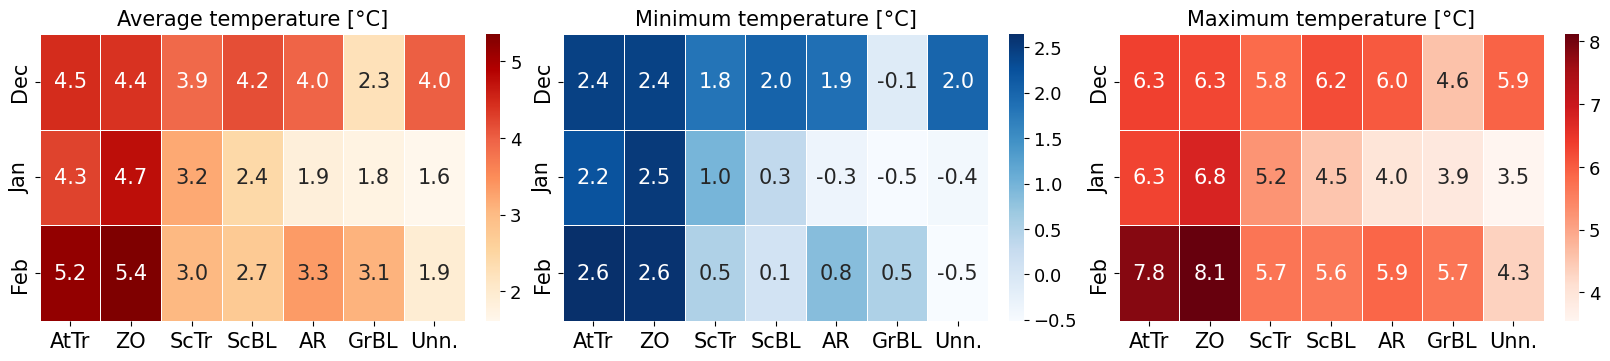

In [95]:
nb_clusters = 7 ; cluster_names = cluster_names_kmeans_7_
avg_temperature, min_temperature, max_temperature, number_of_days_with_temperature = retrieve_temperature_data_for_clusters(y_pred=y_pred_sorted_kmeans_7, nb_clusters=nb_clusters, dataset_dict=dataset_dict)

### One large plot ###
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 3.5), constrained_layout=True)
ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, annot_kws={"size":15}, linewidth=0.5, fmt=".1f", vmin=np.min(avg_temperature), vmax=np.max(avg_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[0])
axs[0].set_title("Average temperature [°C]", fontsize=15) ; axs[0].tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(min_temperature), vmax=np.max(min_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[1])
axs[1].set_title("Minimum temperature [°C]", fontsize=15) ; axs[1].tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(max_temperature), vmax=np.max(max_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[2])
axs[2].set_title("Maximum temperature [°C]", fontsize=15) ; axs[2].tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)
plt.show()

# ### Average temperature per regime ###
# plt.figure(figsize=(6, 3), constrained_layout=True)
# ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=1.5, vmax=5.5, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ax.set_title("Average temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_avg_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

# ### Minimum temperature per regime ###
# plt.figure(figsize=(6, 3), constrained_layout=True)
# # vmin = np.floor(np.min(min_temperature) * 2) / 2 ; vmax = np.ceil(np.max(min_temperature) * 2) / 2 
# ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=-0.5, vmax=2.5, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Minimum temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_min_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

# ### Maximum temperature per regime ###
# plt.figure(figsize=(6, 3), constrained_layout=True)
# ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=3.5, vmax=8, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Maximum temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_max_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

---
### Dimensionality Dependence of K-Means Clustering ###
---

In [6]:
def apply_PCA_Kmeans(nb_modes, nb_clusters, n_init, verbose=False):
    data_for_PCA = dataset_dict["geopotential_height_anomalies_reshaped"]
    start_time = time.time()
    pca = PCA(n_components=nb_modes).fit(data_for_PCA)
    end_time = time.time()
    if (verbose == True): print(f"PCA algorithm with {nb_modes} modes performed in {end_time-start_time:.2f} seconds.")

    explained_variance = pca.explained_variance_ratio_ * 100
    if (verbose == True): print(f"Total explained variance by the first {nb_modes} PCA modes: {explained_variance.sum():.2f}%")

    ### Transform the geopotential height anomalies using the PCA model (Project the data onto the first nb_modes PCA modes) ###
    PCA_transformed_data = pca.transform(data_for_PCA)
    if (verbose == True): 
        print(f"Transformed geopotential height shape: {PCA_transformed_data.shape}")
        print(f"Principal components shape: {pca.components_.shape}")

    data_for_clustering = PCA_transformed_data

    start_time = time.time()
    kmeans = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans = kmeans.predict(data_for_clustering)
    end_time = time.time()
    if (verbose == True): print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

    frequency_array = np.bincount(y_pred_kmeans, minlength=nb_clusters) / len(y_pred_kmeans) * 100
    sorted_indices = np.argsort(frequency_array)[::-1]
    y_pred_sorted = np.array([np.argwhere(sorted_indices == y_pred_kmeans[i])[0][0] for i in range(len(y_pred_kmeans))])
    if (verbose == True): print(f"Frequency of each cluster: {frequency_array[sorted_indices]} \n")

    cluster_centers_original_space = kmeans.cluster_centers_[sorted_indices] @ pca.components_

    return cluster_centers_original_space, y_pred_sorted

In [7]:
def equivalent_predictions_2_configurations(nb_clusters, nb_modes_array, all_centroids, all_y_preds):
    equivalent_predictions = np.zeros((len(nb_modes_array), len(nb_modes_array)))
    for nb_modes_idx_1 in range(len(nb_modes_array)):
        for nb_modes_idx_2 in range(len(nb_modes_array)):
            mapping = np.zeros(nb_clusters, dtype=int)
            for i in range(nb_clusters):
                distances = np.linalg.norm(all_centroids[nb_modes_idx_1][i] - all_centroids[nb_modes_idx_2], axis=1)
                mapping[i] = np.argmin(distances)
            new_predictions = np.array([mapping[y] for y in all_y_preds[nb_modes_idx_1]])
            equivalent_predictions[nb_modes_idx_1, nb_modes_idx_2] = np.sum(new_predictions == all_y_preds[nb_modes_idx_2]) / len(all_y_preds[0]) * 100

    plt.figure(figsize=(6, 6), constrained_layout=True)
    # Mask the lower triangle in the heatmap
    mask = np.tril(np.ones_like(equivalent_predictions, dtype=bool), k=-1)
    sns.heatmap(equivalent_predictions, annot=True, fmt=".1f", cmap="Greens", cbar=False, square=True, linewidths=0.5, vmin=np.min(equivalent_predictions), vmax=100, annot_kws={"fontsize":12}, xticklabels=nb_modes_array, yticklabels=nb_modes_array, mask=mask)
    plt.xlabel("Number of retained PCs", fontsize=15) ; plt.ylabel("Number of retained PCs", fontsize=15) ; axs = plt.gca() ; axs.tick_params(labelsize=15)
    # plt.savefig("Images/KMeans_{nb_clusters}_clusters_equivalent_predictions_with_different_number_of_PCs.png", dpi=300, bbox_inches="tight")
    plt.show()

In [8]:
all_centroids_4_clusters = [] ; nb_modes_array_4_clusters = np.arange(5, 15+1, 1)
all_y_preds_4_clusters = np.zeros((len(nb_modes_array_4_clusters), len(dataset_dict["geopotential_height"])), dtype=int)

nb_clusters = 4 ; n_init = 500
for nb_modes_idx in range(len(nb_modes_array_4_clusters)):
    print(f"Applying K-Means with {nb_clusters} clusters on the data projected onto the first {nb_modes_array_4_clusters[nb_modes_idx]} PCA modes...")
    centroids_original_space_X_Pcs, y_pred_sorted_X_PCs = apply_PCA_Kmeans(nb_modes=nb_modes_array_4_clusters[nb_modes_idx], nb_clusters=nb_clusters, n_init=n_init, verbose=False)
    all_centroids_4_clusters.append(centroids_original_space_X_Pcs) ; all_y_preds_4_clusters[nb_modes_idx] = y_pred_sorted_X_PCs

Applying K-Means with 4 clusters on the data projected onto the first 5 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 6 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 7 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 8 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 9 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 10 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 11 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 12 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 13 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 14 PCA modes...
Applying K-Means with 4 clusters on the data projected onto the first 15 PCA modes...


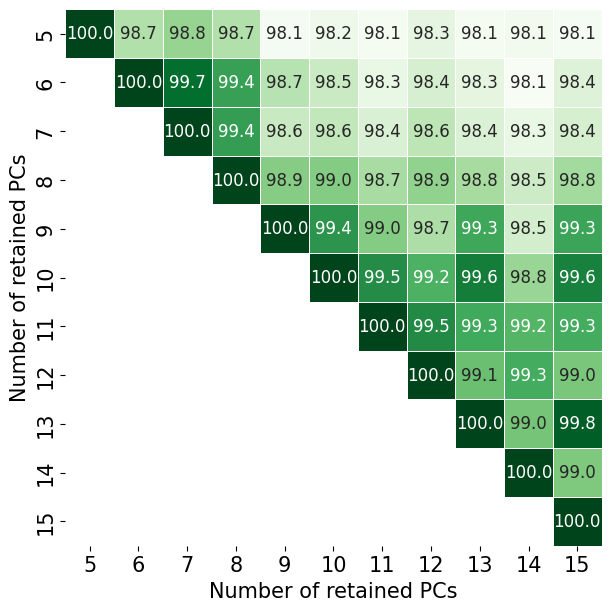

In [9]:
equivalent_predictions_2_configurations(nb_clusters=4, nb_modes_array=nb_modes_array_4_clusters, all_centroids=all_centroids_4_clusters, all_y_preds=all_y_preds_4_clusters)

In [10]:
all_centroids_7_clusters = [] ; nb_modes_array_7_clusters = np.arange(5, 15+1, 1)
all_y_preds_7_clusters = np.zeros((len(nb_modes_array_7_clusters), len(dataset_dict["geopotential_height"])), dtype=int)

nb_clusters = 7 ; n_init = 500
for nb_modes_idx in range(len(nb_modes_array_7_clusters)):
    print(f"Applying K-Means with {nb_clusters} clusters on the data projected onto the first {nb_modes_array_7_clusters[nb_modes_idx]} PCA modes...")
    centroids_original_space_X_Pcs, y_pred_sorted_X_PCs = apply_PCA_Kmeans(nb_modes=nb_modes_array_7_clusters[nb_modes_idx], nb_clusters=nb_clusters, n_init=n_init, verbose=False)
    all_centroids_7_clusters.append(centroids_original_space_X_Pcs) ; all_y_preds_7_clusters[nb_modes_idx] = y_pred_sorted_X_PCs

Applying K-Means with 7 clusters on the data projected onto the first 5 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 6 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 7 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 8 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 9 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 10 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 11 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 12 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 13 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 14 PCA modes...
Applying K-Means with 7 clusters on the data projected onto the first 15 PCA modes...


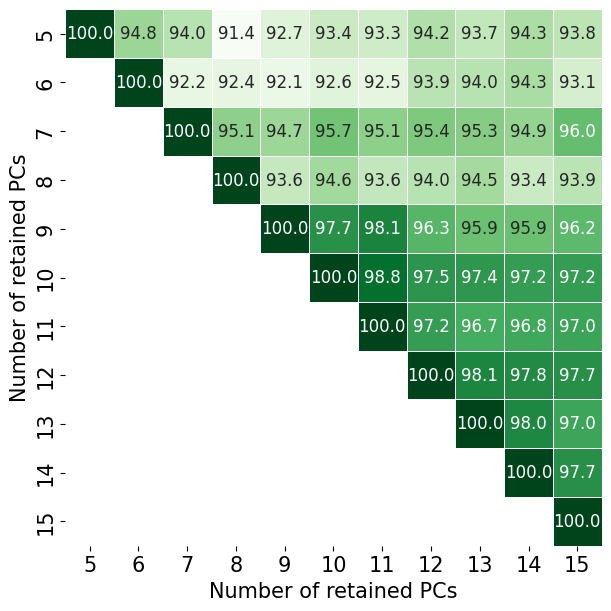

In [11]:
equivalent_predictions_2_configurations(nb_clusters=7, nb_modes_array=nb_modes_array_7_clusters, all_centroids=all_centroids_7_clusters, all_y_preds=all_y_preds_7_clusters)

---
## Optimal number of clusters
---

In [6]:
nb_clusters_array = np.arange(2, 20+1, 1) ; n_init = 1000
inertia_array = [] ; kmeans_models = []
start_total_time = time.time()
for nb_clusters in nb_clusters_array:
    start_time = time.time()
    kmeans = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; inertia_array.append(kmeans.inertia_) ; kmeans_models.append(kmeans)
    end_time = time.time() ; print(f"K-Means with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")
end_total_time = time.time() ; print(f"K-Means clustering for {nb_clusters_array[0]} to {nb_clusters_array[-1]} clusters performed in {end_total_time - start_total_time:.2f} seconds.")

K-Means with 2 clusters performed in 7.71 seconds.
K-Means with 3 clusters performed in 10.69 seconds.
K-Means with 4 clusters performed in 18.24 seconds.
K-Means with 5 clusters performed in 19.82 seconds.
K-Means with 6 clusters performed in 23.54 seconds.
K-Means with 7 clusters performed in 26.84 seconds.
K-Means with 8 clusters performed in 30.71 seconds.
K-Means with 9 clusters performed in 25.72 seconds.
K-Means with 10 clusters performed in 31.74 seconds.
K-Means with 11 clusters performed in 36.92 seconds.
K-Means with 12 clusters performed in 38.22 seconds.
K-Means with 13 clusters performed in 41.52 seconds.
K-Means with 14 clusters performed in 43.20 seconds.
K-Means with 15 clusters performed in 42.26 seconds.
K-Means with 16 clusters performed in 46.20 seconds.
K-Means with 17 clusters performed in 48.72 seconds.
K-Means with 18 clusters performed in 49.09 seconds.
K-Means with 19 clusters performed in 52.94 seconds.
K-Means with 20 clusters performed in 52.88 seconds.
K-

#### Elbow plot ####

Optimal number of clusters: 8


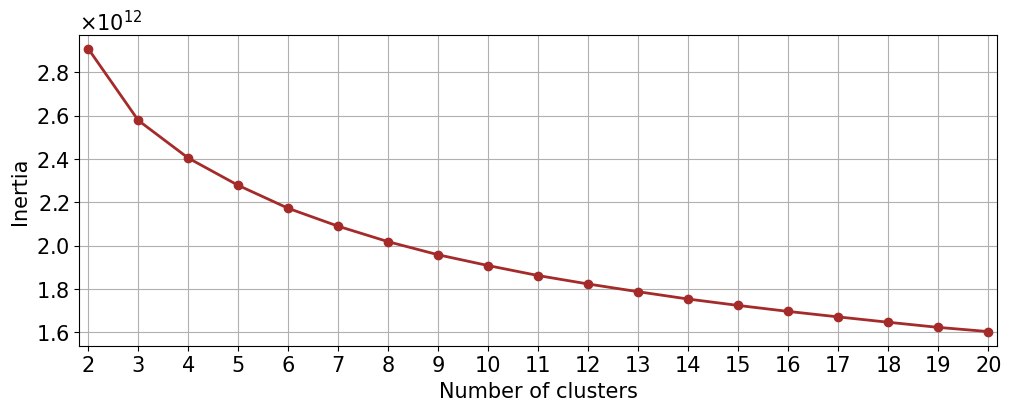

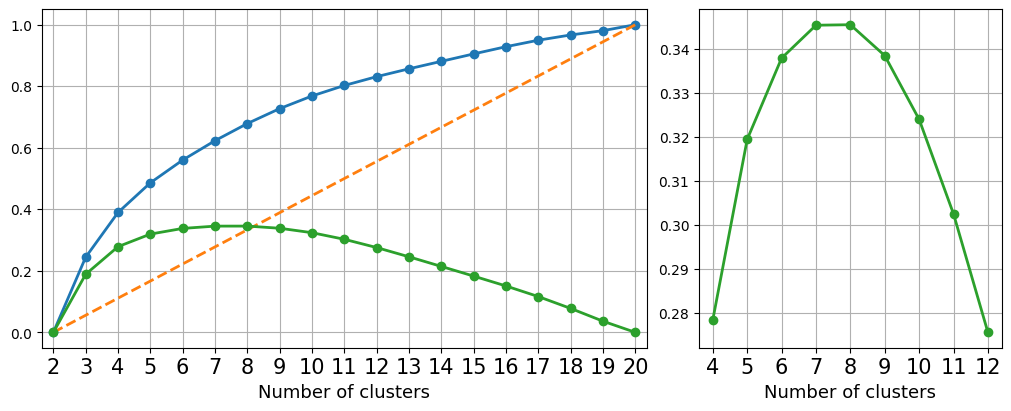

In [ ]:
plt.figure(figsize=(10, 4), constrained_layout=True)
knee = KneeLocator(x=nb_clusters_array, y=inertia_array, S=1, curve='convex', direction='decreasing', interp_method='polynomial')
print(f"Optimal number of clusters: {knee.elbow}")
# plt.vlines(x=knee.elbow, ymin=min(inertia_array), ymax=max(inertia_array), color='r', linestyles='dashed')
plt.plot(nb_clusters_array, inertia_array, marker='o', linewidth=2, color='brown')
plt.xticks(nb_clusters_array, fontsize=15) ; plt.yticks(fontsize=15) ; plt.margins(x=0.01) ; plt.grid()
plt.xlabel("Number of clusters", fontsize=15) ; plt.ylabel("Inertia", fontsize=15) # ; plt.title("Inertia vs Number of clusters")

# Change the fontsize of the units in the y-axis (1e12 above the y-axis)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True)) ; plt.gca().yaxis.get_offset_text().set_fontsize(15)
# plt.savefig("Images/KMeans_inertia_vs_nb_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True, width_ratios=[2, 1])
axs[0].plot(knee.x_normalized, knee.y_normalized, 'o-', label='Inverse inertia KneeLocator', linewidth=2)
axs[0].plot([knee.x_normalized[0], knee.x_normalized[-1]], [knee.y_normalized[0], knee.y_normalized[-1]], linestyle='--', linewidth=2)
axs[0].plot(knee.x_difference, knee.y_difference, 'o-', label='Difference curve KneeLocator', linewidth=2) ; axs[0].margins(x=0.02)
axs[0].grid() ; axs[0].set_xlabel("Number of clusters", fontsize=13) ; axs[0].set_xticks(np.linspace(0, 1, len(inertia_array)), nb_clusters_array, fontsize=15)
lidx = 2 ; uidx = 11
axs[1].plot(knee.x_difference[lidx:uidx], knee.y_difference[lidx:uidx], 'o-', label='Difference curve KneeLocator', color='tab:green', linewidth=2) ; axs[1].margins(x=0.05)
axs[1].grid() ; axs[1].set_xlabel("Number of clusters", fontsize=13) ; axs[1].set_xticks(np.linspace(0, 1, len(inertia_array))[lidx:uidx], nb_clusters_array[lidx:uidx], fontsize=15) 
# plt.savefig("Images/differences_inertia_vs_nb_clusters_KMeans.png", dpi=300, bbox_inches='tight')
plt.show()

#### Evolution of the SSE within each cluster ####

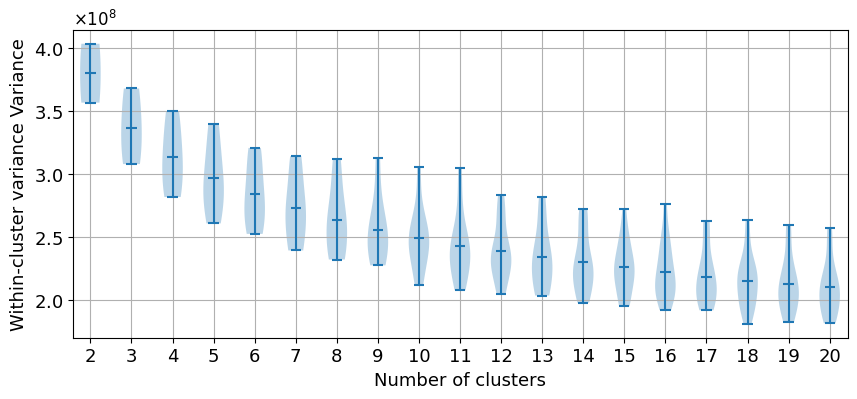

In [ ]:
variance_array = []
for nb_clusters in nb_clusters_array:
    kmeans = kmeans_models[nb_clusters - nb_clusters_array[0]] ; variance_array.append([])
    for k in range(nb_clusters):
        reduced_data = data_for_clustering[kmeans.labels_ == k]
        variance_array[-1].append(np.var(reduced_data, axis=0).sum())

plt.figure(figsize=(10, 4)) ; plt.violinplot(variance_array, positions=nb_clusters_array, showmeans=True, showmedians=False, widths=0.5) ; plt.grid() 
plt.xlabel("Number of clusters", fontsize=13) ; plt.ylabel("Within-cluster variance Variance", fontsize=13) ; plt.margins(x=0.01)
plt.xticks(ticks=nb_clusters_array, labels=nb_clusters_array, fontsize=13) ; ax = plt.gca() ; ax.tick_params(labelsize=13)
from matplotlib.ticker import ScalarFormatter
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True)) ; plt.gca().yaxis.get_offset_text().set_fontsize(12)
# plt.savefig("Images/KMeans_variance_within_clusters_vs_nb_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

#### Silhouette analysis ####

In [11]:
silhouette_scores = [] ; silhouette_samples_array = []
for kmeans in kmeans_models:
    silhouette_samples_array.append(silhouette_samples(data_for_clustering, kmeans.labels_))
    silhouette_scores.append(silhouette_score(data_for_clustering, kmeans.labels_))
    if (np.mean(silhouette_samples_array[-1]) != silhouette_scores[-1]):
        print("Warning: Silhouette score and mean silhouette sample do not match.")
        print(f"Silhouette score: {silhouette_scores[-1]}, Mean silhouette sample: {np.mean(silhouette_samples_array[-1])}")

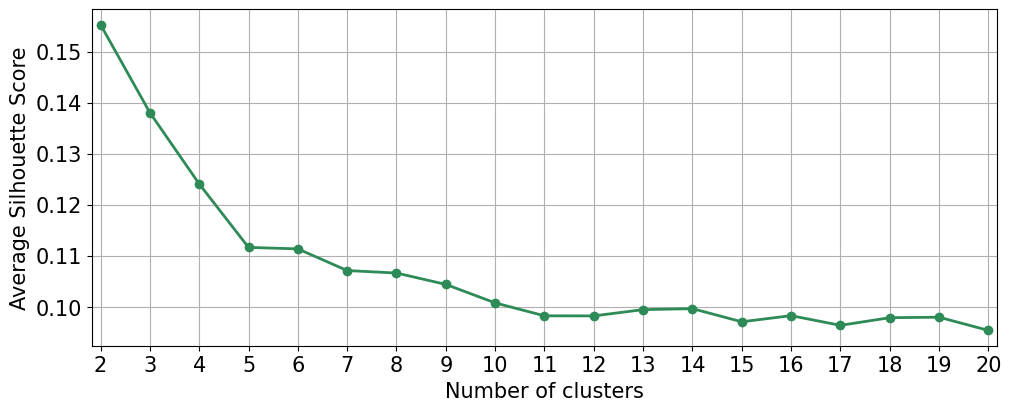

In [ ]:
plt.figure(figsize=(10, 4), constrained_layout=True)
plt.plot(nb_clusters_array, silhouette_scores, marker="o", linewidth=2, color='seagreen')
plt.xticks(nb_clusters_array, fontsize=15) ; plt.yticks(fontsize=15) ; plt.margins(x=0.01) ; plt.grid()
plt.xlabel("Number of clusters", fontsize=15) ; plt.ylabel("Average Silhouette Score", fontsize=15)
# plt.savefig("Images/KMeans_avg_silhouette_score_vs_nb_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

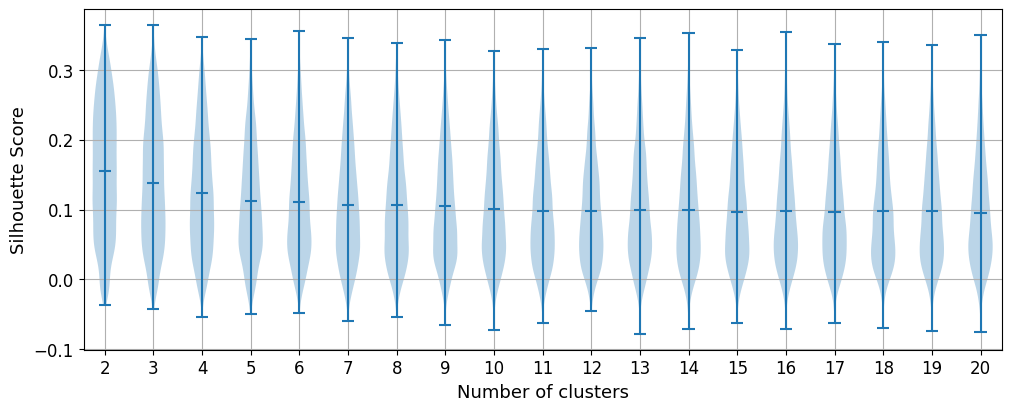

In [15]:
plt.figure(figsize=(10, 4), constrained_layout=True)
plt.violinplot(silhouette_samples_array, positions=nb_clusters_array, showmeans=True, widths=0.5)
# plt.boxplot(silhouette_samples_array, positions=nb_clusters_array, widths=0.5, showmeans=True, meanline=True, meanprops={"linewidth":2}, medianprops={"linewidth":2}, flierprops={"markeredgecolor":"gray"})
# plt.plot(nb_clusters_array, silhouette_scores, marker="o", linewidth=2)
plt.xticks(nb_clusters_array, fontsize=12) ; plt.yticks(fontsize=12) ; plt.margins(x=0.01) ; plt.grid()
plt.xlabel("Number of clusters", fontsize=13) ; plt.ylabel("Silhouette Score", fontsize=13)
# plt.savefig("Images/KMeans_silhouette_score_vs_nb_clusters.png", dpi=300, bbox_inches="tight")
plt.show()

#### Davies-Bouldin and Calinski-Harabasz scores ####

In [17]:
# calinski_harabasz_scores = []
Davies_bouldin_scores = []
for kmeans in kmeans_models:
    # calinski_harabasz_scores.append(calinski_harabasz_score(data_for_clustering, kmeans.labels_))
    Davies_bouldin_scores.append(davies_bouldin_score(data_for_clustering, kmeans.labels_))

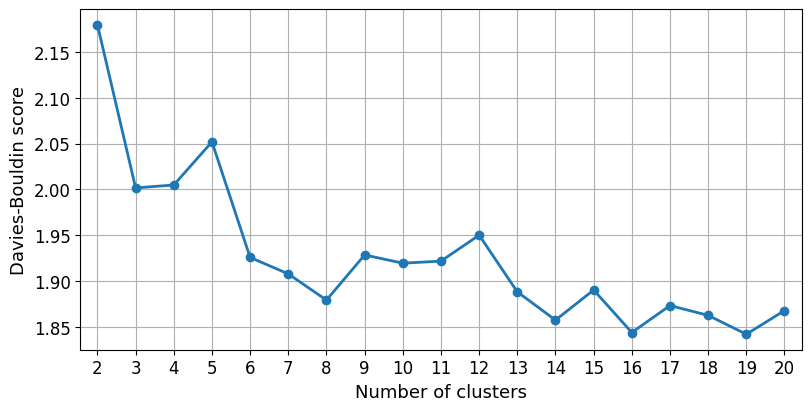

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True)
axs.plot(nb_clusters_array, Davies_bouldin_scores, marker='o', linewidth=2)
axs.set_xticks(nb_clusters_array) ; axs.tick_params(labelsize=12) ; axs.margins(x=0.025) ; axs.grid()
axs.set_xlabel("Number of clusters", fontsize=13) ; axs.set_ylabel("Davies-Bouldin score", fontsize=13)
# plt.savefig(f"Images/Davies_Bouldin_score_vs_nb_clusters_KMeans.png", dpi=300, bbox_inches="tight")
plt.show()

---
## Eight clusters
---

In [13]:
nb_clusters = 8 ; n_init = 500
start_time = time.time()
kmeans_8 = KMeans(n_clusters=nb_clusters, init="k-means++", n_init=n_init).fit(data_for_clustering) ; y_pred_kmeans_8 = kmeans_8.predict(data_for_clustering)
end_time = time.time() ; print(f"K-Means algorithm with {nb_clusters} clusters performed in {end_time-start_time:.2f} seconds.")

frequency_array_kmeans_8 = np.bincount(y_pred_kmeans_8) / len(y_pred_kmeans_8) * 100
sorted_indices_kmeans_8 = np.argsort(frequency_array_kmeans_8)[::-1]
y_pred_sorted_kmeans_8 = np.array([np.argwhere(sorted_indices_kmeans_8 == y_pred_kmeans_8[day])[0][0] for day in range(len(y_pred_kmeans_8))])

K-Means algorithm with 8 clusters performed in 14.49 seconds.


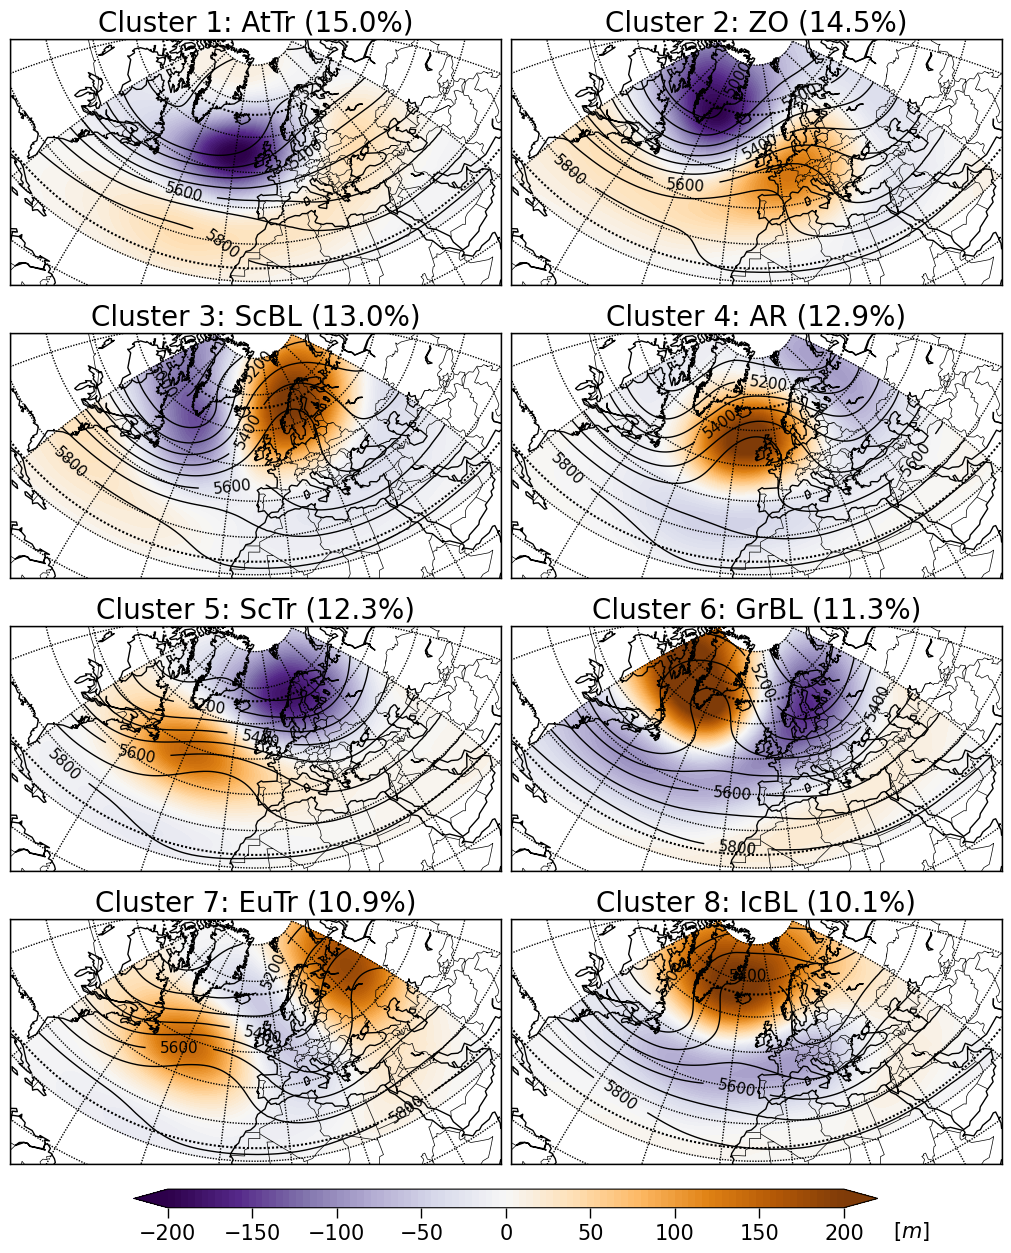

In [14]:
cluster_names_kmeans_8 = ["AtTr", "ZO", "ScBL", "AR", "ScTr", "GrBL", "EuTr", "IcBL"]
plot_centroids(nb_clusters=len(cluster_names_kmeans_8), cluster_centers=kmeans_8.cluster_centers_, y_pred=y_pred_kmeans_8, method="K-Means", cluster_names=cluster_names_kmeans_8, savefig=False)

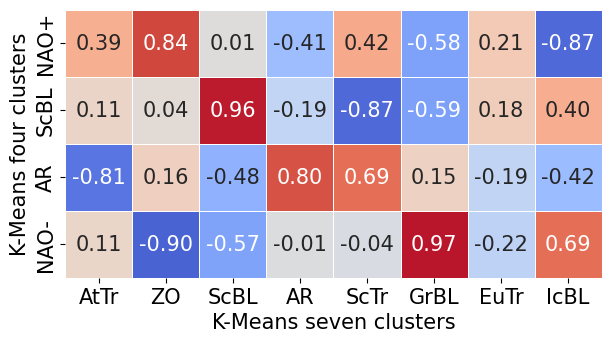

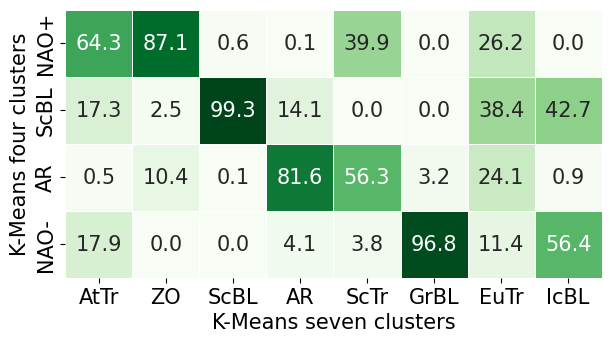

In [15]:
nb_clusters_kmeans_4 = 4 ; nb_clusters_kmeans_8 = 8
cluster_names_kmeans_7_ = np.concatenate((cluster_names_kmeans_7[:-1], ["Unn."])) # ; print(cluster_names_kmeans_8)

# Correlation between the centroids of the different clustering methods
correlation_KMeans_4_vs_7 = np.zeros((nb_clusters_kmeans_4, nb_clusters_kmeans_8))
number_of_similar_predictions = np.zeros((nb_clusters_kmeans_4, nb_clusters_kmeans_8))
for i in range(nb_clusters_kmeans_4):
    for j in range(nb_clusters_kmeans_8):
        correlation_KMeans_4_vs_7[i, j] = np.corrcoef(kmeans_4.cluster_centers_[sorted_indices_kmeans_4[i], :].flatten(), kmeans_8.cluster_centers_[sorted_indices_kmeans_8[j], :].flatten())[0, 1]
        ### Count number of samples within cluster i of KMeans 4 and j of KMeans 7 ###
        mask = (y_pred_sorted_kmeans_4 == i) & (y_pred_sorted_kmeans_8 == j) ; count = np.sum(mask) ; number_of_similar_predictions[i, j] = count / np.sum(y_pred_sorted_kmeans_8 == j) * 100

fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
sns.heatmap(correlation_KMeans_4_vs_7, annot=True, fmt=".2f", annot_kws={"fontsize":15}, cmap="coolwarm", cbar=False, ax=axs, square=True, linewidths=0.5, center=0, vmin=-1, vmax=1)
axs.set_xlabel("K-Means seven clusters", fontsize=15) ; axs.set_ylabel("K-Means four clusters", fontsize=15)
# axs.set_xticklabels(np.arange(nb_clusters_kmeans_8)+1, fontsize=13) ; axs.set_yticklabels(np.arange(nb_clusters_kmeans_4)+1, fontsize=13)
axs.set_xticks(np.arange(nb_clusters_kmeans_8) + 0.5, labels=cluster_names_kmeans_8, fontsize=15) ; axs.set_yticks(np.arange(nb_clusters_kmeans_4) + 0.5, labels=cluster_names_kmeans_4, fontsize=15)
# plt.savefig(f"Images/KMeans_4_vs_7_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
sns.heatmap(number_of_similar_predictions, annot=True, fmt=".1f", annot_kws={"fontsize":15}, cmap="Greens", cbar=False, ax=axs, square=True, linewidths=0.5, vmin=0, vmax=np.max(number_of_similar_predictions))
axs.set_xlabel("K-Means seven clusters", fontsize=15) ; axs.set_ylabel("K-Means four clusters", fontsize=15)
# axs.set_xticklabels(np.arange(nb_clusters_kmeans_8)+1, fontsize=13) ; axs.set_yticklabels(np.arange(nb_clusters_kmeans_4)+1, fontsize=13)
axs.set_xticks(np.arange(nb_clusters_kmeans_8) + 0.5, labels=cluster_names_kmeans_8, fontsize=15) ; axs.set_yticks(np.arange(nb_clusters_kmeans_4) + 0.5, labels=cluster_names_kmeans_4, fontsize=15)
# plt.savefig(f"Images/KMeans_4_vs_7_number_of_similar_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

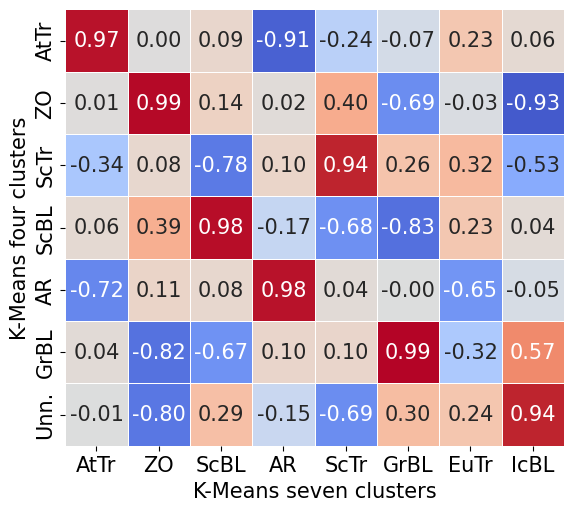

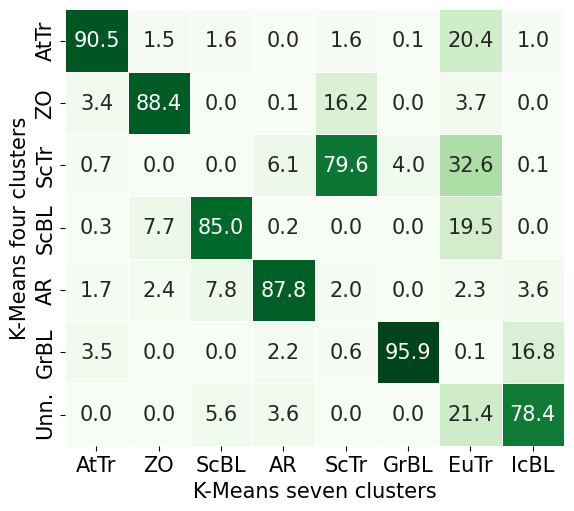

In [16]:
nb_clusters_kmeans_7 = 7 ; nb_clusters_kmeans_8 = 8
cluster_names_kmeans_7_ = np.concatenate((cluster_names_kmeans_7[:-1], ["Unn."])) # ; print(cluster_names_kmeans_8)

# Correlation between the centroids of the different clustering methods
correlation_KMeans_4_vs_7 = np.zeros((nb_clusters_kmeans_7, nb_clusters_kmeans_8))
number_of_similar_predictions = np.zeros((nb_clusters_kmeans_7, nb_clusters_kmeans_8))
for i in range(nb_clusters_kmeans_7):
    for j in range(nb_clusters_kmeans_8):
        correlation_KMeans_4_vs_7[i, j] = np.corrcoef(kmeans_7.cluster_centers_[sorted_indices_kmeans_7[i], :].flatten(), kmeans_8.cluster_centers_[sorted_indices_kmeans_8[j], :].flatten())[0, 1]
        ### Count number of samples within cluster i of KMeans 4 and j of KMeans 7 ###
        mask = (y_pred_sorted_kmeans_7 == i) & (y_pred_sorted_kmeans_8 == j) ; count = np.sum(mask) ; number_of_similar_predictions[i, j] = count / np.sum(y_pred_sorted_kmeans_8 == j) * 100

fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
sns.heatmap(correlation_KMeans_4_vs_7, annot=True, fmt=".2f", annot_kws={"fontsize":15}, cmap="coolwarm", cbar=False, ax=axs, square=True, linewidths=0.5, center=0, vmin=-1, vmax=1)
axs.set_xlabel("K-Means seven clusters", fontsize=15) ; axs.set_ylabel("K-Means four clusters", fontsize=15)
# axs.set_xticklabels(np.arange(nb_clusters_kmeans_8)+1, fontsize=13) ; axs.set_yticklabels(np.arange(nb_clusters_kmeans_4)+1, fontsize=13)
axs.set_xticks(np.arange(nb_clusters_kmeans_8) + 0.5, labels=cluster_names_kmeans_8, fontsize=15) ; axs.set_yticks(np.arange(nb_clusters_kmeans_7) + 0.5, labels=cluster_names_kmeans_7_, fontsize=15)
# plt.savefig(f"Images/KMeans_4_vs_7_correlation.png", dpi=300, bbox_inches="tight")
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(6, 5), constrained_layout=True)
sns.heatmap(number_of_similar_predictions, annot=True, fmt=".1f", annot_kws={"fontsize":15}, cmap="Greens", cbar=False, ax=axs, square=True, linewidths=0.5, vmin=0, vmax=np.max(number_of_similar_predictions))
axs.set_xlabel("K-Means seven clusters", fontsize=15) ; axs.set_ylabel("K-Means four clusters", fontsize=15)
# axs.set_xticklabels(np.arange(nb_clusters_kmeans_8)+1, fontsize=13) ; axs.set_yticklabels(np.arange(nb_clusters_kmeans_4)+1, fontsize=13)
axs.set_xticks(np.arange(nb_clusters_kmeans_8) + 0.5, labels=cluster_names_kmeans_8, fontsize=15) ; axs.set_yticks(np.arange(nb_clusters_kmeans_7) + 0.5, labels=cluster_names_kmeans_7_, fontsize=15)
# plt.savefig(f"Images/KMeans_4_vs_7_number_of_similar_predictions.png", dpi=300, bbox_inches="tight")
plt.show()

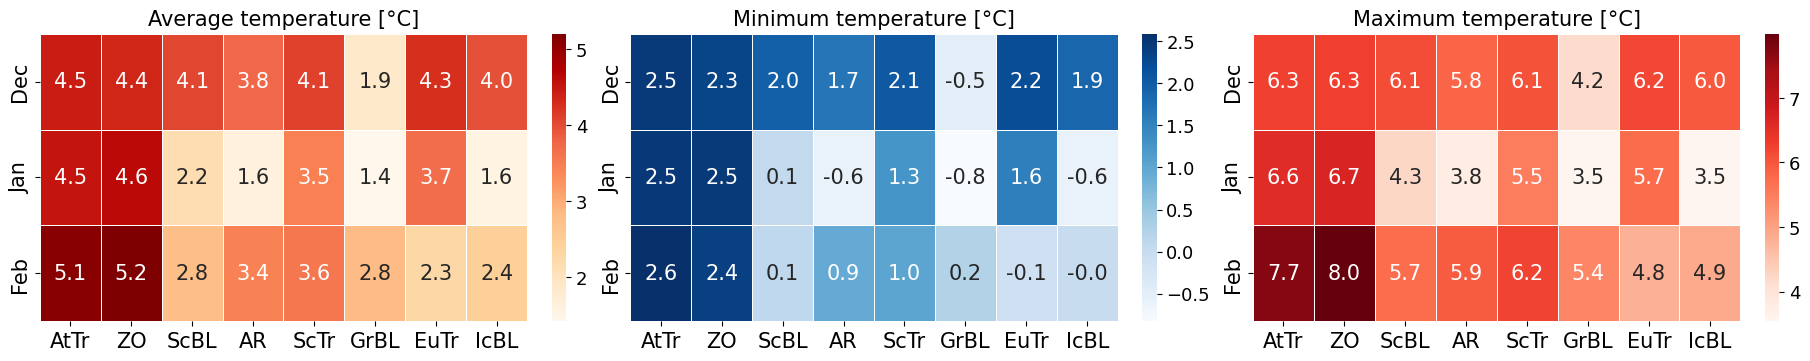

In [106]:
method = "KMeans" ; nb_clusters = 8 ; cluster_names = cluster_names_kmeans_X
avg_temperature, min_temperature, max_temperature, number_of_days_with_temperature = retrieve_temperature_data_for_clusters(y_pred=y_pred_sorted_kmeans_X, nb_clusters=nb_clusters, dataset_dict=dataset_dict)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 3.5), constrained_layout=True)
ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, annot_kws={"size":15}, linewidth=0.5, fmt=".1f", vmin=np.min(avg_temperature), vmax=np.max(avg_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[0])
axs[0].set_title("Average temperature [°C]", fontsize=15) ; axs[0].tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(min_temperature), vmax=np.max(min_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[1])
axs[1].set_title("Minimum temperature [°C]", fontsize=15) ; axs[1].tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)

ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=np.min(max_temperature), vmax=np.max(max_temperature), xticklabels=cluster_names, yticklabels=winter_months, ax=axs[2])
axs[2].set_title("Maximum temperature [°C]", fontsize=15) ; axs[2].tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13)
plt.show()

# ### Average temperature per regime ###
# plt.figure(figsize=(6, 3), constrained_layout=True)
# ax = sns.heatmap(avg_temperature, annot=True, cmap='OrRd', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=1.5, vmax=5.5, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ax.set_title("Average temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_avg_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

# ### Minimum temperature per regime ###
# plt.figure(figsize=(6, 3), constrained_layout=True)
# # vmin = np.floor(np.min(min_temperature) * 2) / 2 ; vmax = np.ceil(np.max(min_temperature) * 2) / 2 
# ax = sns.heatmap(min_temperature, annot=True, cmap='Blues', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=-0.5, vmax=2.5, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Minimum temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_min_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()

# ### Maximum temperature per regime ###
# plt.figure(figsize=(6, 3), constrained_layout=True)
# ax = sns.heatmap(max_temperature, annot=True, cmap='Reds', cbar=True, fmt=".1f", annot_kws={"size":15}, linewidth=0.5, vmin=3.5, vmax=8, xticklabels=cluster_names, yticklabels=winter_months)
# ax.tick_params(labelsize=15) ; cbar_ax = ax.figure.axes[-1] ; cbar_ax.tick_params(labelsize=13) # ; ax.set_title("Maximum temperature [°C]", fontsize=15)
# plt.savefig(f"Images/temperature_max_{method}_{nb_clusters}_clusters.png", dpi=300, bbox_inches="tight")
# plt.show()